In [1]:
import json
import pandas as pd
import numpy as np
import sys
import random
import os.path
import seaborn as sn
from dtreeviz.trees import dtreeviz # will be used for tree visualization
from matplotlib import pyplot as plt
from collections import defaultdict
from sklearn.svm import SVR, SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.metrics import multilabel_confusion_matrix, classification_report, confusion_matrix, explained_variance_score
sys.path.append('./DnD-Battler/')
import DnD

./DnD-Battler/DnD.py:255: UserWarning: Beastiary error, expected path ./beastiary.csv error [Errno 2] No such file or directory: './beastiary.csv'
  warnings.warn('Beastiary error, expected path ' + path + ' error ' + str(e))


In [2]:
url = "https://raw.githubusercontent.com/oganm/dnddata/master/data-raw/dnd_chars_all.json"
df = pd.read_json(url)
df = df.transpose()

In [3]:
ignored = ['ip', 'finger', 'date', 'hash', 'choices', 'name', 'country']
dont_process = ['weapons', 'spells', 'skills']
clean_df = pd.json_normalize(df['name'])
clean_df = clean_df['alias'].str[0]

for key in df.keys():
    if key not in ignored:
        if key in dont_process:
            data = df[key].reset_index(drop=True)
        else:
            try: # try doing a json_normalize, which will fail if it's not a json
                data = pd.json_normalize(df[key])
                for col in data.keys(): # unpack the singletons in each json column
                    data[col] = data[col].str[0]
            except AttributeError: 
                data = df[key].str[0]
                data = data.reset_index(drop=True) # use integer index to conform with json_normalize index

        clean_df = pd.concat([clean_df, data], axis=1)

num_spells = df['spells'].apply(len).reset_index(drop=True)
clean_df['num_spells'] = num_spells

# add generic "primary class" column based on highest level class of character
class_list = ['Artificer.level','Barbarian.level','Bard.level','Cleric.level','Druid.level','Fighter.level','Monk.level','Paladin.level','Ranger.level','Rogue.level','Sorcerer.level','Warlock.level','Wizard.level']
class_df = clean_df[class_list]

primary_class = class_df.idxmax(axis=1)
class1 = list(primary_class.str.split('.').str[0])
clean_df['class1'] = class1

# add generic "primary class level" column/label
primary_class_level = class_df.max(axis=1)
clean_df['level1'] = primary_class_level

# one-hot encode castingStat
castingStat = pd.get_dummies(clean_df["castingStat"], prefix='castingStat')
clean_df = pd.concat([clean_df, castingStat], axis = 1)

# one-hot encode processedRace 
processedRace = pd.get_dummies(clean_df["processedRace"], prefix='processedRace')
clean_df = pd.concat([clean_df, processedRace], axis = 1)

# add hp / level
clean_df['hp_per_lvl'] = clean_df['HP'] / clean_df['level1']

In [4]:
level_groups = ['1-3', '4-7', '8-11', '12-15', '16-18', '19-20']
weapon_info = {'club': 4, 'greatclub': 8,
                           'dagger': 4, 'shortsword': 6, 'longsword': 8, 'bastardsword': 10, 'greatsword': 12,
                           'rapier': 8, 'scimitar': 6, 'sickle': 4,
                           'handaxe': 6, 'battleaxe': 8, 'waraxe': 10, 'greataxe': 12,
                           'javelin': 6, 'spear': 6, 'flail': 8, 'glaive': 10, 'halberd': 10, 'lance': 12, 'pike': 10,
                           'trident': 6,
                           'war pick': 8,
                           'lighthammer': 4, 'mace': 6, 'warhammer': 8,
                            'morningstar': 8, 'punch': 1,
                           'whip': 4}

char_list = {
    '1-3': [],
    '4-7': [], 
    '8-11': [], 
    '12-15': [], 
    '16-18': [], 
    '19-20': []
}

iterations = 2500
#TODO: ignore groups with the exact char combinations as a previous group
# add spells
for group in level_groups:
    grouped_chars = clean_df[clean_df['levelGroup'] == group]
    
    for n in range(iterations):
#         group_size = random.randint(2, 6)
        group_size = 1

        samples = [grouped_chars.sample(group_size), grouped_chars.sample(group_size)]
        chars = []

        for g in range(len(samples)):
            sample = samples[g]
            group_chars = []

            for i in range(len(sample)):
                char = sample.iloc[i]
                weapons = char['weapons']
                weapon_list = []
                for weapon in weapons:
                    if weapons[weapon]['processedWeapon'][0] is not None:
                        weapon_list.append(weapons[weapon]['processedWeapon'][0].lower())

                best_weapon = 'punch'
                for weapon in weapon_list:
                    if weapon in weapon_info and weapon_info[weapon] > weapon_info[best_weapon]:
                        best_weapon = weapon

                group_chars.append(DnD.Creature(f'group_{g}_{i}', abilities={'dex': char['Dex'], 'str': char['Str'], 'cha': char['Cha'], 'con': char['Con'], 
                                              'int': char['Int'], 'wis': char['Wis']}, 
                                                ac=char.AC, hp=char.HP, attack_parameters=best_weapon, 
                                                level=char['level'], alignment=f'group{g}', sc_ability=char['castingStat'].lower() ))

            chars.append(group_chars)

        char_list[group].append(chars)


12 3 1
choice HD... 4.5
10 2 1
choice HD... 4.0
7 1 1
choice HD... 3.0
24 2 3
choice HD... 4.5
21 2 3
choice HD... 3.75
8 2 1
choice HD... 3.0
11 3 1
choice HD... 4.0
16 4 1
choice HD... 6.0
6 0 1
choice HD... 3.0
39 3 3
choice HD... 7.5
34 3 3
choice HD... 6.25
24 2 3
choice HD... 4.5
12 2 1
choice HD... 5.0
12 2 1
choice HD... 5.0
13 2 1
choice HD... 5.5
28 2 3
choice HD... 5.5
25 3 2
choice HD... 6.333333333333333
11 1 1
choice HD... 5.0
52 6 3
choice HD... 8.5
31 3 3
choice HD... 5.5
13 3 1
choice HD... 5.0
23 3 2
choice HD... 5.666666666666667
10 2 1
choice HD... 4.0
11 1 1
choice HD... 5.0
21 1 3
choice HD... 4.5
41 3 3
choice HD... 8.0
12 3 1
choice HD... 4.5
24 2 3
choice HD... 4.5
30 3 3
choice HD... 5.25
20 2 3
choice HD... 3.5
14 2 2
choice HD... 3.3333333333333335
10 2 1
choice HD... 4.0
12 2 1
choice HD... 5.0
31 3 3
choice HD... 5.5
9 2 1
choice HD... 3.5
24 2 3
choice HD... 4.5
22 1 3
choice HD... 4.75
18 1 3
choice HD... 3.75
10 2 1
choice HD... 4.0
10 2 1
choice HD... 

./DnD-Battler/DnD.py:383: UserWarning: Unfinished case to guess HD. so Defaulting hit dice to d8 instead
  warnings.warn('Unfinished case to guess HD. so Defaulting hit dice to d8 instead')  # TODO finish


 1 1
choice HD... 8.0
29 3 3
choice HD... 5.0
22 2 2
choice HD... 6.0
20 2 2
choice HD... 5.333333333333333
29 1 3
choice HD... 6.5
10 2 1
choice HD... 4.0
13 3 1
choice HD... 5.0
7 -1 1
choice HD... 4.0
30 1 3
choice HD... 6.75
9 1 1
choice HD... 4.0
20 2 2
choice HD... 5.333333333333333
23 2 3
choice HD... 4.25
35 3 3
choice HD... 6.5
13 3 1
choice HD... 5.0
32 3 3
choice HD... 5.75
13 -1 3
choice HD... 4.0
9 1 1
choice HD... 4.0
21 1 3
choice HD... 4.5
8 2 1
choice HD... 3.0
36 2 3
choice HD... 7.5
29 3 3
choice HD... 5.0
14 2 1
choice HD... 6.0
9 3 1
choice HD... 3.0
21 2 3
choice HD... 3.75
31 3 3
choice HD... 5.5
20 2 2
choice HD... 5.333333333333333
27 2 3
choice HD... 5.25
24 4 2
choice HD... 5.333333333333333
17 2 2
choice HD... 4.333333333333333
36 3 3
choice HD... 6.75
27 1 3
choice HD... 6.0
29 1 3
choice HD... 6.5
11 1 1
choice HD... 5.0
10 2 1
choice HD... 4.0
9 1 1
choice HD... 4.0
13 1 2
choice HD... 3.6666666666666665
12 2 2
choice HD... 2.6666666666666665
20 3 2
choic

25 3 2
choice HD... 6.333333333333333
9 1 1
choice HD... 4.0
11 1 1
choice HD... 5.0
10 2 1
choice HD... 4.0
15 1 2
choice HD... 4.333333333333333
7 1 1
choice HD... 3.0
9 3 1
choice HD... 3.0
31 3 3
choice HD... 5.5
24 0 3
choice HD... 6.0
12 4 1
choice HD... 4.0
12 2 1
choice HD... 5.0
26 0 3
choice HD... 6.5
28 2 3
choice HD... 5.5
11 3 1
choice HD... 4.0
6 0 1
choice HD... 3.0
29 2 3
choice HD... 5.75
15 3 1
choice HD... 6.0
4 -1 1
choice HD... 2.5
8 2 1
choice HD... 3.0
29 2 3
choice HD... 5.75
27 1 3
choice HD... 6.0
8 2 1
choice HD... 3.0
16 4 1
choice HD... 6.0
15 3 1
choice HD... 6.0
24 0 3
choice HD... 6.0
12 2 1
choice HD... 5.0
10 2 1
choice HD... 4.0
8 2 1
choice HD... 3.0
5 -1 1
choice HD... 3.0
10 2 1
choice HD... 4.0
20 2 2
choice HD... 5.333333333333333
13 3 1
choice HD... 5.0
20 2 2
choice HD... 5.333333333333333
33 3 3
choice HD... 6.0
9 -1 1
choice HD... 5.0
20 2 2
choice HD... 5.333333333333333
10 2 1
choice HD... 4.0
10 2 1
choice HD... 4.0
9 1 1
choice HD... 4.0


27 3 3
choice HD... 4.5
7 1 1
choice HD... 3.0
36 2 3
choice HD... 7.5
10 2 1
choice HD... 4.0
11 1 1
choice HD... 5.0
11 2 1
choice HD... 4.5
25 1 3
choice HD... 5.5
19 3 2
choice HD... 4.333333333333333
24 3 2
choice HD... 6.0
35 3 3
choice HD... 6.5
18 0 3
choice HD... 4.5
10 2 1
choice HD... 4.0
13 3 1
choice HD... 5.0
28 4 2
choice HD... 6.666666666666667
14 2 1
choice HD... 6.0
29 3 3
choice HD... 5.0
13 7 1
choice HD... 3.0
10 2 1
choice HD... 4.0
32 1 2
choice HD... 10.0
34 4 3
choice HD... 5.5
15 3 1
choice HD... 6.0
28 1 3
choice HD... 6.25
8 2 1
choice HD... 3.0
24 2 3
choice HD... 4.5
21 1 3
choice HD... 4.5
12 1 2
choice HD... 3.3333333333333335
33 1 3
choice HD... 7.5
22 3 2
choice HD... 5.333333333333333
8 0 1
choice HD... 4.0
8 0 1
choice HD... 4.0
24 2 3
choice HD... 4.5
11 2 1
choice HD... 4.5
6 2 1
choice HD... 2.0
14 2 1
choice HD... 6.0
9 -1 1
choice HD... 5.0
10 2 1
choice HD... 4.0
21 1 3
choice HD... 4.5
12 2 1
choice HD... 5.0
9 3 1
choice HD... 3.0
12 2 1
choi

32 2 3
choice HD... 6.5
9 1 1
choice HD... 4.0
24 2 3
choice HD... 4.5
24 1 3
choice HD... 5.25
12 2 1
choice HD... 5.0
9 1 1
choice HD... 4.0
23 3 2
choice HD... 5.666666666666667
34 0 3
choice HD... 8.5
22 0 3
choice HD... 5.5
7 1 1
choice HD... 3.0
32 4 2
choice HD... 8.0
38 4 3
choice HD... 6.5
20 2 2
choice HD... 5.333333333333333
9 1 1
choice HD... 4.0
20 2 3
choice HD... 3.5
24 2 3
choice HD... 4.5
14 2 1
choice HD... 6.0
30 3 3
choice HD... 5.25
25 2 3
choice HD... 4.75
9 1 1
choice HD... 4.0
9 1 1
choice HD... 4.0
10 2 1
choice HD... 4.0
14 2 1
choice HD... 6.0
28 2 3
choice HD... 5.5
8 0 1
choice HD... 4.0
36 2 3
choice HD... 7.5
12 2 1
choice HD... 5.0
28 2 3
choice HD... 5.5
34 3 3
choice HD... 6.25
10 0 2
choice HD... 3.3333333333333335
30 3 3
choice HD... 5.25
10 2 1
choice HD... 4.0
12 2 1
choice HD... 5.0
9 1 1
choice HD... 4.0
8 0 1
choice HD... 4.0
18 1 2
choice HD... 5.333333333333333
16 3 1
choice HD... 6.5
25 1 3
choice HD... 5.5
37 3 3
choice HD... 7.0
9 1 1
choic

20 0 2
choice HD... 6.666666666666667
8 2 1
choice HD... 3.0
33 1 3
choice HD... 7.5
17 2 2
choice HD... 4.333333333333333
29 1 3
choice HD... 6.5
24 2 3
choice HD... 4.5
10 2 1
choice HD... 4.0
9 1 1
choice HD... 4.0
20 1 3
choice HD... 4.25
30 3 3
choice HD... 5.25
9 1 1
choice HD... 4.0
12 2 1
choice HD... 5.0
14 4 1
choice HD... 5.0
25 3 2
choice HD... 6.333333333333333
15 1 2
choice HD... 4.333333333333333
35 3 3
choice HD... 6.5
16 3 1
choice HD... 6.5
24 2 3
choice HD... 4.5
30 1 3
choice HD... 6.75
8 2 1
choice HD... 3.0
7 -1 1
choice HD... 4.0
10 2 1
choice HD... 4.0
7 1 1
choice HD... 3.0
14 2 1
choice HD... 6.0
7 1 1
choice HD... 3.0
19 2 2
choice HD... 5.0
8 0 1
choice HD... 4.0
12 2 1
choice HD... 5.0
10 2 1
choice HD... 4.0
14 2 1
choice HD... 6.0
20 1 3
choice HD... 4.25
13 3 1
choice HD... 5.0
15 1 2
choice HD... 4.333333333333333
24 2 3
choice HD... 4.5
11 1 1
choice HD... 5.0
28 2 3
choice HD... 5.5
9 1 1
choice HD... 4.0
23 0 3
choice HD... 5.75
11 5 1
choice HD... 3

9 1 1
choice HD... 4.0
12 2 1
choice HD... 5.0
8 -1 2
choice HD... 3.3333333333333335
4 -1 1
choice HD... 2.5
10 2 1
choice HD... 4.0
10 2 1
choice HD... 4.0
28 3 3
choice HD... 4.75
9 1 1
choice HD... 4.0
8 0 1
choice HD... 4.0
20 2 2
choice HD... 5.333333333333333
9 1 1
choice HD... 4.0
9 1 1
choice HD... 4.0
21 1 3
choice HD... 4.5
11 3 1
choice HD... 4.0
20 1 3
choice HD... 4.25
32 2 3
choice HD... 6.5
9 1 1
choice HD... 4.0
22 3 2
choice HD... 5.333333333333333
11 1 1
choice HD... 5.0
9 3 1
choice HD... 3.0
19 0 3
choice HD... 4.75
8 2 1
choice HD... 3.0
33 2 3
choice HD... 6.75
31 3 3
choice HD... 5.5
20 1 2
choice HD... 6.0
26 2 3
choice HD... 5.0
12 2 1
choice HD... 5.0
21 2 3
choice HD... 3.75
10 2 1
choice HD... 4.0
10 2 1
choice HD... 4.0
11 1 1
choice HD... 5.0
12 2 1
choice HD... 5.0
22 0 3
choice HD... 5.5
24 2 3
choice HD... 4.5
12 1 2
choice HD... 3.3333333333333335
7 -1 1
choice HD... 4.0
9 3 1
choice HD... 3.0
12 2 1
choice HD... 5.0
45 3 3
choice HD... 9.0
20 0 3
cho

10 2 1
choice HD... 4.0
10 2 1
choice HD... 4.0
7 1 1
choice HD... 3.0
9 2 1
choice HD... 3.5
13 3 1
choice HD... 5.0
18 0 3
choice HD... 4.5
12 2 1
choice HD... 5.0
22 1 3
choice HD... 4.75
29 2 3
choice HD... 5.75
9 1 1
choice HD... 4.0
30 1 3
choice HD... 6.75
10 2 1
choice HD... 4.0
8 0 1
choice HD... 4.0
15 1 2
choice HD... 4.333333333333333
10 2 1
choice HD... 4.0
28 2 3
choice HD... 5.5
10 2 1
choice HD... 4.0
9 2 1
choice HD... 3.5
13 3 1
choice HD... 5.0
21 1 3
choice HD... 4.5
12 1 2
choice HD... 3.3333333333333335
11 3 1
choice HD... 4.0
13 0 2
choice HD... 4.333333333333333
9 1 1
choice HD... 4.0
15 0 2
choice HD... 5.0
9 1 1
choice HD... 4.0
10 2 1
choice HD... 4.0
20 2 2
choice HD... 5.333333333333333
10 2 1
choice HD... 4.0
7 0 1
choice HD... 3.5
36 2 3
choice HD... 7.5
21 1 3
choice HD... 4.5
13 3 1
choice HD... 5.0
11 1 1
choice HD... 5.0
24 2 3
choice HD... 4.5
11 1 1
choice HD... 5.0
37 2 3
choice HD... 7.75
9 1 1
choice HD... 4.0
12 2 1
choice HD... 5.0
21 4 2
choic

12 2 1
choice HD... 5.0
13 3 1
choice HD... 5.0
29 2 3
choice HD... 5.75
15 1 2
choice HD... 4.333333333333333
26 2 3
choice HD... 5.0
27 2 3
choice HD... 5.25
12 2 1
choice HD... 5.0
10 0 1
choice HD... 5.0
19 0 3
choice HD... 4.75
23 2 2
choice HD... 6.333333333333333
11 3 1
choice HD... 4.0
25 3 3
choice HD... 4.0
19 3 2
choice HD... 4.333333333333333
14 2 1
choice HD... 6.0
11 3 1
choice HD... 4.0
10 2 1
choice HD... 4.0
16 3 1
choice HD... 6.5
11 1 1
choice HD... 5.0
12 2 1
choice HD... 5.0
35 2 3
choice HD... 7.25
8 0 1
choice HD... 4.0
9 1 1
choice HD... 4.0
21 2 3
choice HD... 3.75
35 3 3
choice HD... 6.5
24 2 3
choice HD... 4.5
14 0 3
choice HD... 3.5
11 1 1
choice HD... 5.0
16 0 3
choice HD... 4.0
10 2 1
choice HD... 4.0
32 2 3
choice HD... 6.5
24 2 2
choice HD... 6.666666666666667
8 2 1
choice HD... 3.0
20 2 2
choice HD... 5.333333333333333
30 2 3
choice HD... 6.0
12 2 1
choice HD... 5.0
28 2 3
choice HD... 5.5
12 2 1
choice HD... 5.0
10 2 1
choice HD... 4.0
21 1 3
choice HD

14 1 1
choice HD... 6.5
12 3 1
choice HD... 4.5
31 3 3
choice HD... 5.5
10 2 1
choice HD... 4.0
11 1 1
choice HD... 5.0
19 3 2
choice HD... 4.333333333333333
24 2 3
choice HD... 4.5
21 3 2
choice HD... 5.0
24 3 2
choice HD... 6.0
27 1 3
choice HD... 6.0
27 3 3
choice HD... 4.5
10 2 1
choice HD... 4.0
21 2 3
choice HD... 3.75
20 2 3
choice HD... 3.5
32 2 3
choice HD... 6.5
11 3 1
choice HD... 4.0
12 2 1
choice HD... 5.0
27 3 3
choice HD... 4.5
13 3 1
choice HD... 5.0
9 -1 1
choice HD... 5.0
11 3 1
choice HD... 4.0
21 1 3
choice HD... 4.5
12 2 1
choice HD... 5.0
8 0 1
choice HD... 4.0
33 1 3
choice HD... 7.5
10 2 1
choice HD... 4.0
10 2 1
choice HD... 4.0
10 2 1
choice HD... 4.0
15 1 2
choice HD... 4.333333333333333
8 1 1
choice HD... 3.5
17 2 2
choice HD... 4.333333333333333
9 1 1
choice HD... 4.0
27 3 3
choice HD... 4.5
10 2 1
choice HD... 4.0
24 2 3
choice HD... 4.5
21 3 2
choice HD... 5.0
15 3 1
choice HD... 6.0
10 4 1
choice HD... 3.0
7 1 1
choice HD... 3.0
12 2 1
choice HD... 5.0
1

8 1 1
choice HD... 3.5
27 3 3
choice HD... 4.5
31 3 3
choice HD... 5.5
12 2 1
choice HD... 5.0
17 2 2
choice HD... 4.333333333333333
7 0 1
choice HD... 3.5
9 1 1
choice HD... 4.0
14 2 2
choice HD... 3.3333333333333335
12 2 1
choice HD... 5.0
20 2 2
choice HD... 5.333333333333333
11 1 1
choice HD... 5.0
15 2 3
choice HD... 2.25
27 3 3
choice HD... 4.5
12 4 1
choice HD... 4.0
21 1 3
choice HD... 4.5
9 1 1
choice HD... 4.0
9 2 1
choice HD... 3.5
40 4 3
choice HD... 7.0
30 2 3
choice HD... 6.0
9 1 1
choice HD... 4.0
9 1 1
choice HD... 4.0
9 1 1
choice HD... 4.0
25 1 3
choice HD... 5.5
8 1 1
choice HD... 3.5
26 1 3
choice HD... 5.75
11 1 1
choice HD... 5.0
12 -1 3
choice HD... 3.75
33 2 3
choice HD... 6.75
10 2 1
choice HD... 4.0
13 3 1
choice HD... 5.0
13 0 2
choice HD... 4.333333333333333
8 2 1
choice HD... 3.0
8 0 1
choice HD... 4.0
31 3 3
choice HD... 5.5
12 2 1
choice HD... 5.0
9 2 1
choice HD... 3.5
23 2 2
choice HD... 6.333333333333333
26 2 3
choice HD... 5.0
11 3 1
choice HD... 4.0


27 1 3
choice HD... 6.0
7 1 1
choice HD... 3.0
5 1 1
choice HD... 2.0
12 4 1
choice HD... 4.0
25 1 3
choice HD... 5.5
11 1 1
choice HD... 5.0
13 3 1
choice HD... 5.0
34 0 3
choice HD... 8.5
10 2 1
choice HD... 4.0
12 3 1
choice HD... 4.5
10 2 1
choice HD... 4.0
15 1 2
choice HD... 4.333333333333333
10 2 1
choice HD... 4.0
2 2 1
choice HD... 0.0
10 2 1
choice HD... 4.0
11 1 1
choice HD... 5.0
32 2 3
choice HD... 6.5
21 1 3
choice HD... 4.5
12 -1 1
choice HD... 6.5
11 3 1
choice HD... 4.0
52 6 3
choice HD... 8.5
15 3 1
choice HD... 6.0
13 3 1
choice HD... 5.0
28 2 3
choice HD... 5.5
18 1 2
choice HD... 5.333333333333333
24 2 3
choice HD... 4.5
8 0 1
choice HD... 4.0
9 1 1
choice HD... 4.0
13 3 1
choice HD... 5.0
20 1 3
choice HD... 4.25
24 2 3
choice HD... 4.5
14 1 2
choice HD... 4.0
11 2 1
choice HD... 4.5
27 2 3
choice HD... 5.25
8 2 1
choice HD... 3.0
11 0 2
choice HD... 3.6666666666666665
9 1 1
choice HD... 4.0
11 3 1
choice HD... 4.0
11 1 1
choice HD... 5.0
10 3 1
choice HD... 3.5
1

21 1 3
choice HD... 4.5
30 2 3
choice HD... 6.0
11 -1 1
choice HD... 6.0
9 1 1
choice HD... 4.0
10 2 1
choice HD... 4.0
33 3 3
choice HD... 6.0
8 3 1
choice HD... 2.5
28 2 3
choice HD... 5.5
7 -1 1
choice HD... 4.0
15 3 1
choice HD... 6.0
12 2 1
choice HD... 5.0
13 3 1
choice HD... 5.0
15 3 1
choice HD... 6.0
10 2 1
choice HD... 4.0
7 0 1
choice HD... 3.5
10 2 1
choice HD... 4.0
15 3 1
choice HD... 6.0
25 2 3
choice HD... 4.75
22 3 3
choice HD... 3.25
11 1 1
choice HD... 5.0
9 2 1
choice HD... 3.5
9 1 1
choice HD... 4.0
12 2 1
choice HD... 5.0
9 1 1
choice HD... 4.0
7 3 1
choice HD... 2.0
10 0 1
choice HD... 5.0
11 1 1
choice HD... 5.0
12 2 1
choice HD... 5.0
24 2 3
choice HD... 4.5
9 1 1
choice HD... 4.0
9 1 1
choice HD... 4.0
38 4 3
choice HD... 6.5
26 2 3
choice HD... 5.0
11 1 1
choice HD... 5.0
12 4 1
choice HD... 4.0
20 3 2
choice HD... 4.666666666666667
7 0 1
choice HD... 3.5
11 2 1
choice HD... 4.5
18 1 2
choice HD... 5.333333333333333
8 0 1
choice HD... 4.0
12 2 1
choice HD... 

7 1 1
choice HD... 3.0
22 1 2
choice HD... 6.666666666666667
14 1 2
choice HD... 4.0
18 2 2
choice HD... 4.666666666666667
18 0 3
choice HD... 4.5
10 2 1
choice HD... 4.0
24 2 3
choice HD... 4.5
4 1 1
choice HD... 1.5
7 1 1
choice HD... 3.0
13 3 1
choice HD... 5.0
25 1 3
choice HD... 5.5
10 2 1
choice HD... 4.0
14 1 2
choice HD... 4.0
23 3 2
choice HD... 5.666666666666667
10 2 1
choice HD... 4.0
16 3 1
choice HD... 6.5
27 1 3
choice HD... 6.0
14 2 1
choice HD... 6.0
10 2 1
choice HD... 4.0
20 2 3
choice HD... 3.5
9 1 1
choice HD... 4.0
13 3 1
choice HD... 5.0
27 2 3
choice HD... 5.25
11 3 1
choice HD... 4.0
8 0 1
choice HD... 4.0
9 2 1
choice HD... 3.5
28 2 3
choice HD... 5.5
9 1 1
choice HD... 4.0
17 2 2
choice HD... 4.333333333333333
24 2 2
choice HD... 6.666666666666667
4 1 1
choice HD... 1.5
10 0 1
choice HD... 5.0
18 1 2
choice HD... 5.333333333333333
10 2 1
choice HD... 4.0
14 2 1
choice HD... 6.0
8 2 1
choice HD... 3.0
34 3 3
choice HD... 6.25
34 2 3
choice HD... 7.0
33 1 3
choi

19 3 2
choice HD... 4.333333333333333
28 2 3
choice HD... 5.5
7 1 1
choice HD... 3.0
28 4 2
choice HD... 6.666666666666667
10 2 1
choice HD... 4.0
31 3 3
choice HD... 5.5
10 2 1
choice HD... 4.0
16 1 2
choice HD... 4.666666666666667
30 1 3
choice HD... 6.75
20 2 3
choice HD... 3.5
27 2 3
choice HD... 5.25
11 3 1
choice HD... 4.0
15 3 1
choice HD... 6.0
9 1 1
choice HD... 4.0
25 1 3
choice HD... 5.5
28 2 3
choice HD... 5.5
5 1 1
choice HD... 2.0
21 0 3
choice HD... 5.25
8 2 1
choice HD... 3.0
24 2 3
choice HD... 4.5
11 3 1
choice HD... 4.0
17 1 2
choice HD... 5.0
44 2 3
choice HD... 9.5
10 2 1
choice HD... 4.0
10 2 1
choice HD... 4.0
7 -1 1
choice HD... 4.0
10 2 1
choice HD... 4.0
18 2 3
choice HD... 3.0
34 4 3
choice HD... 5.5
18 1 3
choice HD... 3.75
32 2 3
choice HD... 6.5
21 1 3
choice HD... 4.5
14 2 1
choice HD... 6.0
28 2 3
choice HD... 5.5
30 4 3
choice HD... 4.5
24 3 3
choice HD... 3.75
22 2 2
choice HD... 6.0
10 3 1
choice HD... 3.5
35 3 3
choice HD... 6.5
10 2 1
choice HD... 4

choice HD... 5.5
41 3 4
choice HD... 5.8
60 3 4
choice HD... 9.6
64 4 6
choice HD... 5.714285714285714
52 2 7
choice HD... 4.75
55 3 5
choice HD... 6.666666666666667
50 2 5
choice HD... 6.666666666666667
60 2 5
choice HD... 8.333333333333334
52 2 6
choice HD... 5.714285714285714
32 1 6
choice HD... 3.7142857142857144
60 3 4
choice HD... 9.6
98 4 7
choice HD... 8.75
17 1 5
choice HD... 2.0
30 1 5
choice HD... 4.166666666666667
67 3 7
choice HD... 5.75
44 2 5
choice HD... 5.666666666666667
39 1 5
choice HD... 5.666666666666667
47 4 4
choice HD... 6.2
20 0 5
choice HD... 3.3333333333333335
55 3 7
choice HD... 4.25
48 2 6
choice HD... 5.142857142857143
40 0 7
choice HD... 5.0
38 0 7
choice HD... 4.75
48 0 5
choice HD... 8.0
51 3 4
choice HD... 7.8
58 3 6
choice HD... 5.714285714285714
42 1 5
choice HD... 6.166666666666667
23 0 4
choice HD... 4.6
65 3 5
choice HD... 8.333333333333334
36 2 4
choice HD... 5.6
50 2 5
choice HD... 6.666666666666667
52 2 7
choice HD... 4.75
41 2 4
choice HD... 6

54 4 6
choice HD... 4.285714285714286
50 2 5
choice HD... 6.666666666666667
60 4 5
choice HD... 6.666666666666667
32 2 5
choice HD... 3.6666666666666665
81 3 6
choice HD... 9.0
64 4 6
choice HD... 5.714285714285714
52 2 5
choice HD... 7.0
31 2 4
choice HD... 4.6
50 4 5
choice HD... 5.0
44 2 5
choice HD... 5.666666666666667
26 2 4
choice HD... 3.6
55 2 5
choice HD... 7.5
38 2 4
choice HD... 6.0
43 3 5
choice HD... 4.666666666666667
53 2 5
choice HD... 7.166666666666667
57 1 7
choice HD... 6.25
35 2 4
choice HD... 5.4
46 0 7
choice HD... 5.75
43 3 5
choice HD... 4.666666666666667
40 0 5
choice HD... 6.666666666666667
50 2 7
choice HD... 4.5
25 1 4
choice HD... 4.2
46 2 5
choice HD... 6.0
32 2 4
choice HD... 4.8
49 3 5
choice HD... 5.666666666666667
53 3 4
choice HD... 8.2
39 3 5
choice HD... 4.0
50 3 5
choice HD... 5.833333333333333
48 2 6
choice HD... 5.142857142857143
17 1 5
choice HD... 2.0
40 2 4
choice HD... 6.4
38 2 5
choice HD... 4.666666666666667
47 4 4
choice HD... 6.2
34 1 6
ch

31 1 5
choice HD... 4.333333333333333
39 -1 6
choice HD... 6.428571428571429
63 3 5
choice HD... 8.0
30 1 5
choice HD... 4.166666666666667
41 2 5
choice HD... 5.166666666666667
66 4 7
choice HD... 4.75
65 3 6
choice HD... 6.714285714285714
53 2 6
choice HD... 5.857142857142857
55 3 5
choice HD... 6.666666666666667
38 2 5
choice HD... 4.666666666666667
40 3 4
choice HD... 5.6
27 1 5
choice HD... 3.6666666666666665
28 1 5
choice HD... 3.8333333333333335
47 1 7
choice HD... 5.0
37 2 5
choice HD... 4.5
55 2 7
choice HD... 5.125
24 3 4
choice HD... 2.4
26 0 4
choice HD... 5.2
21 1 4
choice HD... 3.4
67 3 6
choice HD... 7.0
28 0 4
choice HD... 5.6
46 1 6
choice HD... 5.714285714285714
45 2 6
choice HD... 4.714285714285714
74 3 6
choice HD... 8.0
44 2 7
choice HD... 3.75
45 4 4
choice HD... 5.8
40 1 4
choice HD... 7.2
35 2 4
choice HD... 5.4
85 3 7
choice HD... 8.0
53 3 7
choice HD... 4.0
69 1 7
choice HD... 7.75
35 3 4
choice HD... 4.6
38 2 5
choice HD... 4.666666666666667
33 1 5
choice HD..

choice HD... 7.2
22 0 5
choice HD... 3.6666666666666665
42 2 6
choice HD... 4.285714285714286
35 3 4
choice HD... 4.6
41 1 5
choice HD... 6.0
55 3 5
choice HD... 6.666666666666667
59 2 6
choice HD... 6.714285714285714
55 3 5
choice HD... 6.666666666666667
58 3 6
choice HD... 5.714285714285714
24 3 5
choice HD... 1.5
45 2 5
choice HD... 5.833333333333333
31 3 4
choice HD... 3.8
32 0 4
choice HD... 6.4
44 2 5
choice HD... 5.666666666666667
48 3 5
choice HD... 5.5
40 1 7
choice HD... 4.125
30 2 4
choice HD... 4.4
57 2 7
choice HD... 5.375
52 2 7
choice HD... 4.75
54 3 6
choice HD... 5.142857142857143
70 2 7
choice HD... 7.0
35 0 5
choice HD... 5.833333333333333
45 1 7
choice HD... 4.75
62 2 6
choice HD... 7.142857142857143
67 3 7
choice HD... 5.75
40 3 4
choice HD... 5.6
46 1 6
choice HD... 5.714285714285714
51 3 6
choice HD... 4.714285714285714
34 1 4
choice HD... 6.0
84 3 7
choice HD... 7.875
24 2 4
choice HD... 3.2
55 2 7
choice HD... 5.125
55 3 5
choice HD... 6.666666666666667
47 1 7


31 1 5
choice HD... 4.333333333333333
58 3 6
choice HD... 5.714285714285714
60 2 6
choice HD... 6.857142857142857
38 2 5
choice HD... 4.666666666666667
39 1 6
choice HD... 4.714285714285714
34 1 4
choice HD... 6.0
40 2 4
choice HD... 6.4
44 3 4
choice HD... 6.4
31 2 4
choice HD... 4.6
1 2 6
choice HD... -1.5714285714285714
43 3 5
choice HD... 4.666666666666667
70 3 6
choice HD... 7.428571428571429
54 2 7
choice HD... 5.0
84 4 6
choice HD... 8.571428571428571
28 2 5
choice HD... 3.0
37 3 5
choice HD... 3.6666666666666665
64 2 7
choice HD... 6.25
70 2 7
choice HD... 7.0
38 2 5
choice HD... 4.666666666666667
50 2 5
choice HD... 6.666666666666667
59 4 6
choice HD... 5.0
60 2 5
choice HD... 8.333333333333334
40 3 5
choice HD... 4.166666666666667
39 0 5
choice HD... 6.5
39 3 4
choice HD... 5.4
9 2 4
choice HD... 0.2
48 2 5
choice HD... 6.333333333333333
39 2 5
choice HD... 4.833333333333333
42 1 6
choice HD... 5.142857142857143
41 3 5
choice HD... 4.333333333333333
53 2 6
choice HD... 5.8571

60 2 7
choice HD... 5.75
23 -1 5
choice HD... 4.666666666666667
47 3 6
choice HD... 4.142857142857143
24 2 4
choice HD... 3.2
31 2 4
choice HD... 4.6
53 1 6
choice HD... 6.714285714285714
45 2 5
choice HD... 5.833333333333333
45 3 4
choice HD... 6.6
31 5 6
choice HD... 0.14285714285714285
54 2 7
choice HD... 5.0
27 0 5
choice HD... 4.5
46 2 5
choice HD... 6.0
31 2 4
choice HD... 4.6
46 2 5
choice HD... 6.0
44 1 6
choice HD... 5.428571428571429
61 1 5
choice HD... 9.333333333333334
30 2 5
choice HD... 3.3333333333333335
35 1 4
choice HD... 6.2
43 2 4
choice HD... 7.0
31 2 4
choice HD... 4.6
162 2 6
choice HD... 21.428571428571427
52 2 6
choice HD... 5.714285714285714
49 3 5
choice HD... 5.666666666666667
36 0 6
choice HD... 5.142857142857143
45 3 5
choice HD... 5.0
28 1 4
choice HD... 4.8
38 2 5
choice HD... 4.666666666666667
36 0 5
choice HD... 6.0
44 1 5
choice HD... 6.5
43 3 4
choice HD... 6.2
47 3 6
choice HD... 4.142857142857143
30 0 6
choice HD... 4.285714285714286
64 1 6
choice H

49 3 5
choice HD... 5.666666666666667
27 1 4
choice HD... 4.6
30 0 5
choice HD... 5.0
37 2 6
choice HD... 3.5714285714285716
40 1 6
choice HD... 4.857142857142857
48 4 5
choice HD... 4.666666666666667
32 2 4
choice HD... 4.8
33 2 5
choice HD... 3.8333333333333335
18 0 4
choice HD... 3.6
69 1 7
choice HD... 7.75
37 2 5
choice HD... 4.5
31 2 4
choice HD... 4.6
54 2 5
choice HD... 7.333333333333333
31 2 4
choice HD... 4.6
26 2 4
choice HD... 3.6
31 2 4
choice HD... 4.6
106 5 7
choice HD... 8.875
38 2 5
choice HD... 4.666666666666667
28 -1 4
choice HD... 6.4
45 3 4
choice HD... 6.6
44 2 5
choice HD... 5.666666666666667
53 1 6
choice HD... 6.714285714285714
36 2 4
choice HD... 5.6
35 2 6
choice HD... 3.2857142857142856
40 3 4
choice HD... 5.6
35 2 4
choice HD... 5.4
24 1 4
choice HD... 4.0
49 2 5
choice HD... 6.5
46 1 6
choice HD... 5.714285714285714
38 2 5
choice HD... 4.666666666666667
48 2 6
choice HD... 5.142857142857143
44 2 5
choice HD... 5.666666666666667
40 1 7
choice HD... 4.125
40

50 2 5
choice HD... 6.666666666666667
38 2 5
choice HD... 4.666666666666667
30 3 4
choice HD... 3.6
27 0 5
choice HD... 4.5
25 0 4
choice HD... 5.0
45 2 6
choice HD... 4.714285714285714
42 3 5
choice HD... 4.5
40 2 5
choice HD... 5.0
55 3 5
choice HD... 6.666666666666667
36 2 4
choice HD... 5.6
30 3 6
choice HD... 1.7142857142857142
63 1 7
choice HD... 7.0
36 2 5
choice HD... 4.333333333333333
45 2 6
choice HD... 4.714285714285714
52 2 6
choice HD... 5.714285714285714
68 2 6
choice HD... 8.0
46 0 5
choice HD... 7.666666666666667
55 3 5
choice HD... 6.666666666666667
52 3 4
choice HD... 8.0
50 4 4
choice HD... 6.8
37 2 5
choice HD... 4.5
56 2 6
choice HD... 6.285714285714286
25 1 4
choice HD... 4.2
45 3 4
choice HD... 6.6
26 1 4
choice HD... 4.4
16 -1 4
choice HD... 4.0
59 2 5
choice HD... 8.166666666666666
36 2 4
choice HD... 5.6
39 1 6
choice HD... 4.714285714285714
44 2 5
choice HD... 5.666666666666667
32 1 4
choice HD... 5.6
30 1 5
choice HD... 4.166666666666667
38 2 6
choice HD... 

39 1 6
choice HD... 4.714285714285714
44 2 5
choice HD... 5.666666666666667
11 1 4
choice HD... 1.4
33 1 4
choice HD... 5.8
52 3 5
choice HD... 6.166666666666667
56 2 6
choice HD... 6.285714285714286
65 2 5
choice HD... 9.166666666666666
30 2 6
choice HD... 2.5714285714285716
91 3 7
choice HD... 8.75
56 4 4
choice HD... 8.0
51 3 6
choice HD... 4.714285714285714
52 2 7
choice HD... 4.75
36 2 4
choice HD... 5.6
33 0 4
choice HD... 6.6
53 1 6
choice HD... 6.714285714285714
45 1 5
choice HD... 6.666666666666667
54 3 5
choice HD... 6.5
48 1 7
choice HD... 5.125
50 2 7
choice HD... 4.5
23 0 4
choice HD... 4.6
50 5 5
choice HD... 4.166666666666667
41 1 6
choice HD... 5.0
34 1 4
choice HD... 6.0
60 3 5
choice HD... 7.5
28 0 4
choice HD... 5.6
41 2 4
choice HD... 6.6
34 4 5
choice HD... 2.3333333333333335
36 2 4
choice HD... 5.6
43 3 4
choice HD... 6.2
51 2 7
choice HD... 4.625
66 3 7
choice HD... 5.625
49 3 4
choice HD... 7.4
41 2 4
choice HD... 6.6
33 1 4
choice HD... 5.8
24 1 5
choice HD... 

38 2 5
choice HD... 4.666666666666667
23 0 4
choice HD... 4.6
44 1 6
choice HD... 5.428571428571429
36 2 4
choice HD... 5.6
33 1 5
choice HD... 4.666666666666667
47 1 6
choice HD... 5.857142857142857
56 2 5
choice HD... 7.666666666666667
53 2 6
choice HD... 5.857142857142857
62 2 7
choice HD... 6.0
33 1 5
choice HD... 4.666666666666667
50 4 5
choice HD... 5.0
40 2 4
choice HD... 6.4
33 1 5
choice HD... 4.666666666666667
33 1 5
choice HD... 4.666666666666667
41 2 4
choice HD... 6.6
102 4 7
choice HD... 9.25
66 3 7
choice HD... 5.625
40 2 5
choice HD... 5.0
36 3 4
choice HD... 4.8
23 0 4
choice HD... 4.6
30 1 4
choice HD... 5.2
51 3 4
choice HD... 7.8
49 3 6
choice HD... 4.428571428571429
44 2 5
choice HD... 5.666666666666667
51 3 6
choice HD... 4.714285714285714
38 1 4
choice HD... 6.8
56 3 5
choice HD... 6.833333333333333
60 4 5
choice HD... 6.666666666666667
69 1 7
choice HD... 7.75
56 2 5
choice HD... 7.666666666666667
43 3 5
choice HD... 4.666666666666667
38 3 4
choice HD... 5.2
67 

51 4 5
choice HD... 5.166666666666667
30 3 4
choice HD... 3.6
24 3 5
choice HD... 1.5
47 1 5
choice HD... 7.0
38 3 4
choice HD... 5.2
83 4 6
choice HD... 8.428571428571429
52 1 7
choice HD... 5.625
50 3 4
choice HD... 7.6
34 2 4
choice HD... 5.2
28 2 4
choice HD... 4.0
35 3 4
choice HD... 4.6
95 3 7
choice HD... 9.25
32 1 4
choice HD... 5.6
49 4 4
choice HD... 6.6
75 3 7
choice HD... 6.75
50 2 7
choice HD... 4.5
58 1 6
choice HD... 7.428571428571429
33 1 4
choice HD... 5.8
42 3 5
choice HD... 4.5
1 4 5
choice HD... -3.1666666666666665
44 2 4
choice HD... 7.2
38 2 6
choice HD... 3.7142857142857144
22 1 4
choice HD... 3.6
49 3 5
choice HD... 5.666666666666667
65 2 7
choice HD... 6.375
48 4 5
choice HD... 4.666666666666667
28 -1 4
choice HD... 6.4
48 2 5
choice HD... 6.333333333333333
74 3 7
choice HD... 6.625
35 2 4
choice HD... 5.4
38 2 4
choice HD... 6.0
59 2 6
choice HD... 6.714285714285714
52 3 4
choice HD... 8.0
32 1 5
choice HD... 4.5
51 3 6
choice HD... 4.714285714285714
64 1 7
ch

66 5 6
choice HD... 5.142857142857143
56 2 5
choice HD... 7.666666666666667
38 2 5
choice HD... 4.666666666666667
39 2 4
choice HD... 6.2
26 2 5
choice HD... 2.6666666666666665
37 2 4
choice HD... 5.8
45 3 4
choice HD... 6.6
41 2 5
choice HD... 5.166666666666667
66 2 7
choice HD... 6.5
26 3 5
choice HD... 1.8333333333333333
40 2 5
choice HD... 5.0
47 3 4
choice HD... 7.0
45 2 6
choice HD... 4.714285714285714
45 1 7
choice HD... 4.75
51 2 7
choice HD... 4.625
43 3 5
choice HD... 4.666666666666667
67 3 7
choice HD... 5.75
53 2 6
choice HD... 5.857142857142857
54 1 6
choice HD... 6.857142857142857
39 -1 6
choice HD... 6.428571428571429
38 1 6
choice HD... 4.571428571428571
49 2 5
choice HD... 6.5
48 -1 6
choice HD... 7.714285714285714
31 2 4
choice HD... 4.6
49 3 5
choice HD... 5.666666666666667
51 3 6
choice HD... 4.714285714285714
33 1 5
choice HD... 4.666666666666667
44 2 7
choice HD... 3.75
24 2 4
choice HD... 3.2
65 3 6
choice HD... 6.714285714285714
36 3 4
choice HD... 4.8
88 3 7
ch

42 1 6
choice HD... 5.142857142857143
20 -1 4
choice HD... 4.8
44 2 5
choice HD... 5.666666666666667
78 2 7
choice HD... 8.0
36 1 5
choice HD... 5.166666666666667
53 3 6
choice HD... 5.0
54 2 6
choice HD... 6.0
40 2 5
choice HD... 5.0
51 3 6
choice HD... 4.714285714285714
42 3 5
choice HD... 4.5
33 0 4
choice HD... 6.6
47 1 5
choice HD... 7.0
38 2 5
choice HD... 4.666666666666667
33 1 4
choice HD... 5.8
36 1 5
choice HD... 5.166666666666667
65 2 7
choice HD... 6.375
65 3 7
choice HD... 5.5
40 2 5
choice HD... 5.0
46 2 5
choice HD... 6.0
37 2 4
choice HD... 5.8
45 2 6
choice HD... 4.714285714285714
23 0 4
choice HD... 4.6
36 2 4
choice HD... 5.6
40 3 4
choice HD... 5.6
35 3 4
choice HD... 4.6
39 -1 6
choice HD... 6.428571428571429
45 1 5
choice HD... 6.666666666666667
57 2 7
choice HD... 5.375
48 2 6
choice HD... 5.142857142857143
35 2 5
choice HD... 4.166666666666667
35 3 4
choice HD... 4.6
23 0 4
choice HD... 4.6
43 3 4
choice HD... 6.2
69 4 5
choice HD... 8.166666666666666
33 3 4
cho

36 1 5
choice HD... 5.166666666666667
25 2 4
choice HD... 3.4
42 2 6
choice HD... 4.285714285714286
25 1 4
choice HD... 4.2
45 3 5
choice HD... 5.0
51 4 6
choice HD... 3.857142857142857
48 2 5
choice HD... 6.333333333333333
52 2 7
choice HD... 4.75
25 0 4
choice HD... 5.0
40 3 4
choice HD... 5.6
65 4 6
choice HD... 5.857142857142857
47 1 7
choice HD... 5.0
38 2 4
choice HD... 6.0
75 3 7
choice HD... 6.75
39 2 5
choice HD... 4.833333333333333
66 2 6
choice HD... 7.714285714285714
28 0 4
choice HD... 5.6
55 2 6
choice HD... 6.142857142857143
60 2 6
choice HD... 6.857142857142857
36 2 4
choice HD... 5.6
33 2 4
choice HD... 5.0
67 3 7
choice HD... 5.75
43 3 5
choice HD... 4.666666666666667
56 2 5
choice HD... 7.666666666666667
22 0 4
choice HD... 4.4
106 5 7
choice HD... 8.875
50 2 5
choice HD... 6.666666666666667
55 3 5
choice HD... 6.666666666666667
32 2 5
choice HD... 3.6666666666666665
67 2 7
choice HD... 6.625
56 2 6
choice HD... 6.285714285714286
55 3 5
choice HD... 6.666666666666667

choice HD... 4.285714285714286
55 3 5
choice HD... 6.666666666666667
39 3 4
choice HD... 5.4
45 -1 7
choice HD... 6.5
52 3 4
choice HD... 8.0
39 1 6
choice HD... 4.714285714285714
67 3 6
choice HD... 7.0
41 2 5
choice HD... 5.166666666666667
70 2 7
choice HD... 7.0
26 2 4
choice HD... 3.6
39 1 5
choice HD... 5.666666666666667
45 1 5
choice HD... 6.666666666666667
49 2 5
choice HD... 6.5
44 2 5
choice HD... 5.666666666666667
49 3 4
choice HD... 7.4
36 0 6
choice HD... 5.142857142857143
83 3 10
choice HD... 4.818181818181818
85 0 10
choice HD... 7.7272727272727275
83 3 10
choice HD... 4.818181818181818
63 2 9
choice HD... 4.5
102 4 8
choice HD... 7.777777777777778
60 3 9
choice HD... 3.3
73 2 10
choice HD... 4.818181818181818
90 2 8
choice HD... 8.222222222222221
85 3 10
choice HD... 5.0
65 1 10
choice HD... 5.0
59 2 8
choice HD... 4.777777777777778
59 1 9
choice HD... 5.0
69 2 9
choice HD... 5.1
84 3 9
choice HD... 5.7
62 1 8
choice HD... 6.0
100 3 8
choice HD... 8.444444444444445
102 3

59 2 8
choice HD... 4.777777777777778
59 3 8
choice HD... 3.888888888888889
66 2 9
choice HD... 4.8
76 2 9
choice HD... 5.8
104 5 8
choice HD... 7.111111111111111
59 2 8
choice HD... 4.777777777777778
75 3 10
choice HD... 4.090909090909091
65 2 10
choice HD... 4.090909090909091
104 4 10
choice HD... 5.818181818181818
101 5 8
choice HD... 6.777777777777778
41 1 8
choice HD... 3.6666666666666665
76 3 8
choice HD... 5.777777777777778
73 2 10
choice HD... 4.818181818181818
86 3 10
choice HD... 5.090909090909091
70 2 10
choice HD... 4.545454545454546
93 3 10
choice HD... 5.7272727272727275
67 3 8
choice HD... 4.777777777777778
101 5 8
choice HD... 6.777777777777778
119 3 10
choice HD... 8.090909090909092
64 2 8
choice HD... 5.333333333333333
61 2 9
choice HD... 4.3
84 2 8
choice HD... 7.555555555555555
40 -1 8
choice HD... 5.333333333333333
84 3 10
choice HD... 4.909090909090909
59 2 8
choice HD... 4.777777777777778
152 4 11
choice HD... 9.0
86 3 10
choice HD... 5.090909090909091
46 0 11
ch

68 2 11
choice HD... 3.8333333333333335
83 3 10
choice HD... 4.818181818181818
95 5 8
choice HD... 6.111111111111111
57 1 9
choice HD... 4.8
50 0 8
choice HD... 5.555555555555555
86 2 9
choice HD... 6.8
77 0 10
choice HD... 7.0
68 4 8
choice HD... 4.0
35 -1 8
choice HD... 4.777777777777778
84 2 8
choice HD... 7.555555555555555
50 0 8
choice HD... 5.555555555555555
75 3 9
choice HD... 4.8
17 3 8
choice HD... -0.7777777777777778
105 4 9
choice HD... 6.9
90 3 10
choice HD... 5.454545454545454
76 1 10
choice HD... 6.0
62 3 8
choice HD... 4.222222222222222
63 -1 9
choice HD... 7.2
135 5 9
choice HD... 9.0
111 3 9
choice HD... 8.4
140 4 10
choice HD... 9.090909090909092
46 1 8
choice HD... 4.222222222222222
95 2 9
choice HD... 7.7
104 4 8
choice HD... 8.0
104 4 8
choice HD... 8.0
113 5 9
choice HD... 6.8
111 2 10
choice HD... 8.272727272727273
109 3 9
choice HD... 8.2
101 5 8
choice HD... 6.777777777777778
121 4 9
choice HD... 8.5
114 5 10
choice HD... 5.818181818181818
73 2 10
choice HD... 

73 0 9
choice HD... 7.3
101 5 8
choice HD... 6.777777777777778
70 2 8
choice HD... 6.0
66 4 8
choice HD... 3.7777777777777777
36 0 8
choice HD... 4.0
43 -1 10
choice HD... 4.818181818181818
75 4 8
choice HD... 4.777777777777778
85 3 8
choice HD... 6.777777777777778
82 3 10
choice HD... 4.7272727272727275
143 3 11
choice HD... 9.166666666666666
59 2 8
choice HD... 4.777777777777778
96 2 9
choice HD... 7.8
59 2 8
choice HD... 4.777777777777778
108 3 8
choice HD... 9.333333333333334
66 2 9
choice HD... 4.8
88 4 8
choice HD... 6.222222222222222
101 5 8
choice HD... 6.777777777777778
71 2 10
choice HD... 4.636363636363637
59 2 8
choice HD... 4.777777777777778
68 1 8
choice HD... 6.666666666666667
84 1 10
choice HD... 6.7272727272727275
63 1 10
choice HD... 4.818181818181818
60 2 8
choice HD... 4.888888888888889
68 2 8
choice HD... 5.777777777777778
135 5 9
choice HD... 9.0
83 3 9
choice HD... 5.6
42 0 10
choice HD... 3.8181818181818183
68 2 8
choice HD... 5.777777777777778
62 2 8
choice HD.

88 2 11
choice HD... 5.5
79 2 8
choice HD... 7.0
85 0 10
choice HD... 7.7272727272727275
59 3 8
choice HD... 3.888888888888889
90 3 10
choice HD... 5.454545454545454
46 1 8
choice HD... 4.222222222222222
138 3 10
choice HD... 9.818181818181818
86 4 10
choice HD... 4.181818181818182
63 2 9
choice HD... 4.5
100 3 9
choice HD... 7.3
62 2 8
choice HD... 5.111111111111111
62 1 8
choice HD... 6.0
65 2 10
choice HD... 4.090909090909091
84 3 9
choice HD... 5.7
101 3 9
choice HD... 7.4
75 3 8
choice HD... 5.666666666666667
88 2 9
choice HD... 7.0
35 3 9
choice HD... 0.8
73 2 10
choice HD... 4.818181818181818
121 3 11
choice HD... 7.333333333333333
92 3 11
choice HD... 4.916666666666667
73 3 8
choice HD... 5.444444444444445
69 2 9
choice HD... 5.1
68 1 10
choice HD... 5.2727272727272725
114 5 8
choice HD... 8.222222222222221
49 0 8
choice HD... 5.444444444444445
59 2 8
choice HD... 4.777777777777778
66 2 9
choice HD... 4.8
59 2 8
choice HD... 4.777777777777778
52 1 9
choice HD... 4.3
114 5 8
cho

67 2 11
choice HD... 3.75
94 3 10
choice HD... 5.818181818181818
58 2 8
choice HD... 4.666666666666667
67 3 8
choice HD... 4.777777777777778
73 2 10
choice HD... 4.818181818181818
90 3 10
choice HD... 5.454545454545454
51 1 8
choice HD... 4.777777777777778
67 2 8
choice HD... 5.666666666666667
66 2 9
choice HD... 4.8
75 3 10
choice HD... 4.090909090909091
45 1 8
choice HD... 4.111111111111111
85 2 9
choice HD... 6.7
88 2 10
choice HD... 6.181818181818182
66 4 8
choice HD... 3.7777777777777777
80 1 9
choice HD... 7.1
76 1 10
choice HD... 6.0
109 3 11
choice HD... 6.333333333333333
125 5 11
choice HD... 5.833333333333333
78 3 10
choice HD... 4.363636363636363
56 2 8
choice HD... 4.444444444444445
66 3 8
choice HD... 4.666666666666667
51 1 8
choice HD... 4.777777777777778
83 3 10
choice HD... 4.818181818181818
63 1 10
choice HD... 4.818181818181818
88 3 8
choice HD... 7.111111111111111
135 5 9
choice HD... 9.0
93 2 10
choice HD... 6.636363636363637
74 2 8
choice HD... 6.444444444444445
10

66 2 8
choice HD... 5.555555555555555
88 4 8
choice HD... 6.222222222222222
67 3 8
choice HD... 4.777777777777778
84 2 10
choice HD... 5.818181818181818
36 0 8
choice HD... 4.0
69 4 8
choice HD... 4.111111111111111
35 -1 8
choice HD... 4.777777777777778
86 3 10
choice HD... 5.090909090909091
124 4 10
choice HD... 7.636363636363637
83 4 8
choice HD... 5.666666666666667
67 2 8
choice HD... 5.666666666666667
72 3 9
choice HD... 4.5
51 1 8
choice HD... 4.777777777777778
68 2 9
choice HD... 5.0
100 3 8
choice HD... 8.444444444444445
58 3 8
choice HD... 3.7777777777777777
91 3 8
choice HD... 7.444444444444445
74 3 8
choice HD... 5.555555555555555
97 3 11
choice HD... 5.333333333333333
77 4 8
choice HD... 5.0
111 2 10
choice HD... 8.272727272727273
63 -1 9
choice HD... 7.2
62 2 8
choice HD... 5.111111111111111
70 2 8
choice HD... 6.0
96 3 8
choice HD... 8.0
120 3 8
choice HD... 10.666666666666666
73 2 10
choice HD... 4.818181818181818
127 4 10
choice HD... 7.909090909090909
100 4 10
choice HD

80 2 8
choice HD... 7.111111111111111
84 2 8
choice HD... 7.555555555555555
100 2 11
choice HD... 6.5
93 2 10
choice HD... 6.636363636363637
129 4 9
choice HD... 9.3
143 3 11
choice HD... 9.166666666666666
65 3 8
choice HD... 4.555555555555555
66 2 9
choice HD... 4.8
80 2 10
choice HD... 5.454545454545454
64 3 8
choice HD... 4.444444444444445
160 4 10
choice HD... 10.909090909090908
132 3 11
choice HD... 8.25
69 2 8
choice HD... 5.888888888888889
60 3 9
choice HD... 3.3
58 0 9
choice HD... 5.8
104 3 8
choice HD... 8.88888888888889
101 3 10
choice HD... 6.454545454545454
101 3 10
choice HD... 6.454545454545454
110 3 10
choice HD... 7.2727272727272725
46 1 8
choice HD... 4.222222222222222
50 3 8
choice HD... 2.888888888888889
73 2 10
choice HD... 4.818181818181818
72 3 8
choice HD... 5.333333333333333
77 3 8
choice HD... 5.888888888888889
51 1 8
choice HD... 4.777777777777778
90 3 9
choice HD... 6.3
83 4 8
choice HD... 5.666666666666667
77 0 10
choice HD... 7.0
100 4 8
choice HD... 7.555

choice HD... 7.1
146 4 8
choice HD... 12.666666666666666
53 3 11
choice HD... 1.6666666666666667
89 4 8
choice HD... 6.333333333333333
115 2 10
choice HD... 8.636363636363637
76 2 9
choice HD... 5.8
84 3 9
choice HD... 5.7
72 3 10
choice HD... 3.8181818181818183
92 2 11
choice HD... 5.833333333333333
83 1 9
choice HD... 7.4
71 2 8
choice HD... 6.111111111111111
115 4 10
choice HD... 6.818181818181818
96 3 8
choice HD... 8.0
84 4 8
choice HD... 5.777777777777778
56 2 8
choice HD... 4.444444444444445
152 4 11
choice HD... 9.0
62 1 8
choice HD... 6.0
73 2 10
choice HD... 4.818181818181818
90 3 10
choice HD... 5.454545454545454
59 1 8
choice HD... 5.666666666666667
73 2 10
choice HD... 4.818181818181818
62 1 8
choice HD... 6.0
128 5 11
choice HD... 6.083333333333333
74 2 8
choice HD... 6.444444444444445
42 1 8
choice HD... 3.7777777777777777
138 4 10
choice HD... 8.909090909090908
74 1 10
choice HD... 5.818181818181818
82 3 9
choice HD... 5.5
80 4 8
choice HD... 5.333333333333333
56 2 8
ch

60 2 9
choice HD... 4.2
62 2 8
choice HD... 5.111111111111111
86 3 10
choice HD... 5.090909090909091
85 3 9
choice HD... 5.8
95 2 9
choice HD... 7.7
101 5 8
choice HD... 6.777777777777778
81 2 9
choice HD... 6.3
85 3 9
choice HD... 5.8
59 2 8
choice HD... 4.777777777777778
63 1 10
choice HD... 4.818181818181818
84 2 8
choice HD... 7.555555555555555
79 2 10
choice HD... 5.363636363636363
56 1 8
choice HD... 5.333333333333333
82 4 10
choice HD... 3.8181818181818183
51 1 8
choice HD... 4.777777777777778
66 2 9
choice HD... 4.8
54 0 10
choice HD... 4.909090909090909
76 3 8
choice HD... 5.777777777777778
67 2 8
choice HD... 5.666666666666667
67 3 8
choice HD... 4.777777777777778
91 3 8
choice HD... 7.444444444444445
69 0 10
choice HD... 6.2727272727272725
52 0 8
choice HD... 5.777777777777778
-1 2 8
choice HD... -1.8888888888888888
47 1 9
choice HD... 3.8
100 2 10
choice HD... 7.2727272727272725
73 2 10
choice HD... 4.818181818181818
100 4 10
choice HD... 5.454545454545454
104 5 8
choice HD

88 2 10
choice HD... 6.181818181818182
75 3 9
choice HD... 4.8
101 3 10
choice HD... 6.454545454545454
101 5 8
choice HD... 6.777777777777778
98 3 10
choice HD... 6.181818181818182
54 1 11
choice HD... 3.5833333333333335
49 0 8
choice HD... 5.444444444444445
67 2 8
choice HD... 5.666666666666667
76 3 8
choice HD... 5.777777777777778
90 2 8
choice HD... 8.222222222222221
67 1 9
choice HD... 5.8
101 5 8
choice HD... 6.777777777777778
138 3 10
choice HD... 9.818181818181818
51 1 8
choice HD... 4.777777777777778
65 3 8
choice HD... 4.555555555555555
45 1 8
choice HD... 4.111111111111111
68 2 8
choice HD... 5.777777777777778
95 3 8
choice HD... 7.888888888888889
100 2 11
choice HD... 6.5
109 3 9
choice HD... 8.2
130 4 9
choice HD... 9.4
76 2 8
choice HD... 6.666666666666667
105 3 8
choice HD... 9.0
110 1 11
choice HD... 8.25
69 2 9
choice HD... 5.1
47 2 8
choice HD... 3.4444444444444446
45 0 9
choice HD... 4.5
58 3 8
choice HD... 3.7777777777777777
51 1 8
choice HD... 4.777777777777778
67 2

49 3 8
choice HD... 2.7777777777777777
95 2 10
choice HD... 6.818181818181818
54 2 9
choice HD... 3.6
96 2 8
choice HD... 8.88888888888889
132 4 11
choice HD... 7.333333333333333
93 4 10
choice HD... 4.818181818181818
96 4 8
choice HD... 7.111111111111111
66 2 9
choice HD... 4.8
100 3 8
choice HD... 8.444444444444445
130 3 10
choice HD... 9.090909090909092
67 2 8
choice HD... 5.666666666666667
83 4 8
choice HD... 5.666666666666667
75 3 9
choice HD... 4.8
67 3 8
choice HD... 4.777777777777778
98 3 10
choice HD... 6.181818181818182
104 2 10
choice HD... 7.636363636363637
114 5 8
choice HD... 8.222222222222221
96 2 9
choice HD... 7.8
74 2 8
choice HD... 6.444444444444445
68 2 8
choice HD... 5.777777777777778
122 4 8
choice HD... 10.0
84 3 9
choice HD... 5.7
122 4 11
choice HD... 6.5
63 2 9
choice HD... 4.5
-24 -3 8
choice HD... 0.0
90 3 10
choice HD... 5.454545454545454
69 1 9
choice HD... 6.0
96 2 9
choice HD... 7.8
99 3 9
choice HD... 7.2
53 3 11
choice HD... 1.6666666666666667
69 1 11


63 1 8
choice HD... 6.111111111111111
46 1 8
choice HD... 4.222222222222222
56 2 8
choice HD... 4.444444444444445
81 0 10
choice HD... 7.363636363636363
135 5 9
choice HD... 9.0
75 2 8
choice HD... 6.555555555555555
66 1 8
choice HD... 6.444444444444445
71 1 10
choice HD... 5.545454545454546
84 1 9
choice HD... 7.5
143 3 11
choice HD... 9.166666666666666
85 3 9
choice HD... 5.8
54 2 8
choice HD... 4.222222222222222
88 2 9
choice HD... 7.0
103 3 9
choice HD... 7.6
59 2 8
choice HD... 4.777777777777778
85 3 8
choice HD... 6.777777777777778
120 3 8
choice HD... 10.666666666666666
49 1 8
choice HD... 4.555555555555555
77 3 9
choice HD... 5.0
67 3 8
choice HD... 4.777777777777778
72 3 8
choice HD... 5.333333333333333
139 3 11
choice HD... 8.833333333333334
99 3 10
choice HD... 6.2727272727272725
84 3 9
choice HD... 5.7
120 4 8
choice HD... 9.777777777777779
75 3 10
choice HD... 4.090909090909091
96 4 10
choice HD... 5.090909090909091
59 2 8
choice HD... 4.777777777777778
93 2 10
choice HD..

108 2 9
choice HD... 9.0
89 1 10
choice HD... 7.181818181818182
63 1 8
choice HD... 6.111111111111111
53 0 10
choice HD... 4.818181818181818
108 4 8
choice HD... 8.444444444444445
122 3 10
choice HD... 8.363636363636363
40 -1 8
choice HD... 5.333333333333333
57 1 9
choice HD... 4.8
85 3 10
choice HD... 5.0
74 3 8
choice HD... 5.555555555555555
33 0 8
choice HD... 3.6666666666666665
51 1 8
choice HD... 4.777777777777778
96 4 10
choice HD... 5.090909090909091
95 4 11
choice HD... 4.25
86 2 10
choice HD... 6.0
88 0 11
choice HD... 7.333333333333333
68 2 9
choice HD... 5.0
80 3 8
choice HD... 6.222222222222222
80 4 8
choice HD... 5.333333333333333
84 2 8
choice HD... 7.555555555555555
59 2 8
choice HD... 4.777777777777778
73 2 10
choice HD... 4.818181818181818
77 3 8
choice HD... 5.888888888888889
85 2 9
choice HD... 6.7
100 2 11
choice HD... 6.5
75 3 8
choice HD... 5.666666666666667
76 1 10
choice HD... 6.0
71 2 8
choice HD... 6.111111111111111
121 4 9
choice HD... 8.5
57 1 9
choice HD...

114 4 11
choice HD... 5.833333333333333
69 1 11
choice HD... 4.833333333333333
138 4 10
choice HD... 8.909090909090908
59 2 8
choice HD... 4.777777777777778
115 3 11
choice HD... 6.833333333333333
61 3 8
choice HD... 4.111111111111111
90 3 10
choice HD... 5.454545454545454
104 3 8
choice HD... 8.88888888888889
96 2 8
choice HD... 8.88888888888889
95 2 9
choice HD... 7.7
170 5 10
choice HD... 10.909090909090908
59 2 8
choice HD... 4.777777777777778
107 3 9
choice HD... 8.0
98 3 10
choice HD... 6.181818181818182
66 4 8
choice HD... 3.7777777777777777
75 3 9
choice HD... 4.8
54 2 9
choice HD... 3.6
90 3 10
choice HD... 5.454545454545454
96 4 8
choice HD... 7.111111111111111
114 5 10
choice HD... 5.818181818181818
92 3 11
choice HD... 4.916666666666667
53 1 8
choice HD... 5.0
57 1 8
choice HD... 5.444444444444445
99 3 10
choice HD... 6.2727272727272725
60 1 10
choice HD... 4.545454545454546
81 0 10
choice HD... 7.363636363636363
90 4 8
choice HD... 6.444444444444445
51 2 10
choice HD... 2.

96 4 9
choice HD... 6.0
116 4 10
choice HD... 6.909090909090909
96 4 9
choice HD... 6.0
57 1 8
choice HD... 5.444444444444445
45 0 10
choice HD... 4.090909090909091
130 4 10
choice HD... 8.181818181818182
61 1 11
choice HD... 4.166666666666667
73 2 9
choice HD... 5.5
78 3 8
choice HD... 6.0
73 2 9
choice HD... 5.5
94 1 10
choice HD... 7.636363636363637
46 0 10
choice HD... 4.181818181818182
100 2 10
choice HD... 7.2727272727272725
72 1 8
choice HD... 7.111111111111111
66 2 9
choice HD... 4.8
52 0 8
choice HD... 5.777777777777778
73 2 10
choice HD... 4.818181818181818
137 5 11
choice HD... 6.833333333333333
82 4 10
choice HD... 3.8181818181818183
140 4 10
choice HD... 9.090909090909092
90 3 10
choice HD... 5.454545454545454
49 0 8
choice HD... 5.444444444444445
75 3 8
choice HD... 5.666666666666667
114 3 10
choice HD... 7.636363636363637
93 3 10
choice HD... 5.7272727272727275
40 -1 8
choice HD... 5.333333333333333
71 3 8
choice HD... 5.222222222222222
48 0 10
choice HD... 4.36363636363

choice HD... 8.444444444444445
48 0 8
choice HD... 5.333333333333333
102 4 10
choice HD... 5.636363636363637
100 3 8
choice HD... 8.444444444444445
67 2 11
choice HD... 3.75
52 1 9
choice HD... 4.3
84 2 10
choice HD... 5.818181818181818
56 2 8
choice HD... 4.444444444444445
80 2 8
choice HD... 7.111111111111111
77 2 10
choice HD... 5.181818181818182
73 2 9
choice HD... 5.5
94 3 10
choice HD... 5.818181818181818
73 2 10
choice HD... 4.818181818181818
105 3 8
choice HD... 9.0
59 2 8
choice HD... 4.777777777777778
120 4 10
choice HD... 7.2727272727272725
104 3 8
choice HD... 8.88888888888889
88 3 8
choice HD... 7.111111111111111
64 2 8
choice HD... 5.333333333333333
78 2 9
choice HD... 6.0
80 0 10
choice HD... 7.2727272727272725
101 5 8
choice HD... 6.777777777777778
59 2 8
choice HD... 4.777777777777778
67 3 8
choice HD... 4.777777777777778
107 3 10
choice HD... 7.0
53 0 10
choice HD... 4.818181818181818
104 3 8
choice HD... 8.88888888888889
73 2 10
choice HD... 4.818181818181818
66 2 9


75 4 8
choice HD... 4.777777777777778
68 4 8
choice HD... 4.0
114 3 10
choice HD... 7.636363636363637
200 2 8
choice HD... 20.444444444444443
104 3 8
choice HD... 8.88888888888889
77 0 10
choice HD... 7.0
86 4 8
choice HD... 6.0
57 1 9
choice HD... 4.8
67 3 8
choice HD... 4.777777777777778
99 3 10
choice HD... 6.2727272727272725
75 3 10
choice HD... 4.090909090909091
95 3 9
choice HD... 6.8
152 4 10
choice HD... 10.181818181818182
75 3 9
choice HD... 4.8
59 2 8
choice HD... 4.777777777777778
67 3 8
choice HD... 4.777777777777778
146 4 8
choice HD... 12.666666666666666
92 2 10
choice HD... 6.545454545454546
83 3 10
choice HD... 4.818181818181818
69 1 10
choice HD... 5.363636363636363
64 2 10
choice HD... 4.0
55 0 9
choice HD... 5.5
76 3 8
choice HD... 5.777777777777778
47 2 8
choice HD... 3.4444444444444446
152 4 10
choice HD... 10.181818181818182
70 1 10
choice HD... 5.454545454545454
88 2 10
choice HD... 6.181818181818182
100 2 10
choice HD... 7.2727272727272725
59 2 8
choice HD... 4.

200 3 15
choice HD... 9.6875
138 4 15
choice HD... 4.875
112 2 12
choice HD... 6.769230769230769
86 3 12
choice HD... 3.8461538461538463
149 4 15
choice HD... 5.5625
69 1 13
choice HD... 4.0
136 4 13
choice HD... 6.0
101 2 14
choice HD... 4.866666666666666
75 1 12
choice HD... 4.846153846153846
162 4 12
choice HD... 8.76923076923077
149 5 12
choice HD... 6.846153846153846
225 5 15
choice HD... 9.375
180 2 15
choice HD... 9.375
87 2 12
choice HD... 4.846153846153846
143 3 14
choice HD... 6.733333333333333
88 0 14
choice HD... 5.866666666666666
111 3 12
choice HD... 5.769230769230769
120 4 13
choice HD... 4.857142857142857
150 2 15
choice HD... 7.5
87 2 12
choice HD... 4.846153846153846
100 2 12
choice HD... 5.846153846153846
149 5 13
choice HD... 6.0
100 3 14
choice HD... 3.8666666666666667
16 4 13
choice HD... -2.5714285714285716
225 5 15
choice HD... 9.375
122 1 12
choice HD... 8.461538461538462
153 3 14
choice HD... 7.4
103 2 15
choice HD... 4.5625
146 4 13
choice HD... 6.71428571428

116 3 12
choice HD... 6.153846153846154
111 4 12
choice HD... 4.846153846153846
96 2 12
choice HD... 5.538461538461538
113 2 12
choice HD... 6.846153846153846
69 0 12
choice HD... 5.3076923076923075
72 1 13
choice HD... 4.214285714285714
176 5 12
choice HD... 8.923076923076923
100 2 12
choice HD... 5.846153846153846
82 2 13
choice HD... 4.0
116 3 12
choice HD... 6.153846153846154
128 3 15
choice HD... 5.1875
62 1 12
choice HD... 3.8461538461538463
204 5 12
choice HD... 11.076923076923077
120 4 13
choice HD... 4.857142857142857
94 0 14
choice HD... 6.266666666666667
132 2 15
choice HD... 6.375
104 1 12
choice HD... 7.076923076923077
137 4 15
choice HD... 4.8125
120 2 12
choice HD... 7.384615384615385
119 2 15
choice HD... 5.5625
129 3 14
choice HD... 5.8
131 3 15
choice HD... 5.375
87 1 14
choice HD... 4.866666666666666
108 2 15
choice HD... 4.875
98 3 12
choice HD... 4.769230769230769
118 1 15
choice HD... 6.4375
156 3 15
choice HD... 6.9375
138 4 14
choice HD... 5.466666666666667
92 3

134 3 15
choice HD... 5.5625
101 2 14
choice HD... 4.866666666666666
118 2 15
choice HD... 5.5
220 4 15
choice HD... 10.0
104 3 12
choice HD... 5.230769230769231
216 4 15
choice HD... 9.75
83 2 13
choice HD... 4.071428571428571
138 3 12
choice HD... 7.846153846153846
99 3 12
choice HD... 4.846153846153846
167 3 15
choice HD... 7.625
70 4 12
choice HD... 1.6923076923076923
124 4 12
choice HD... 5.846153846153846
92 2 14
choice HD... 4.266666666666667
134 3 15
choice HD... 5.5625
180 3 12
choice HD... 11.076923076923077
232 4 15
choice HD... 10.75
94 2 12
choice HD... 5.384615384615385
168 4 12
choice HD... 9.23076923076923
173 5 14
choice HD... 6.866666666666666
158 3 14
choice HD... 7.733333333333333
134 4 12
choice HD... 6.615384615384615
108 3 15
choice HD... 3.9375
120 3 13
choice HD... 5.785714285714286
93 3 13
choice HD... 3.857142857142857
122 4 15
choice HD... 3.875
51 -1 12
choice HD... 4.846153846153846
157 5 15
choice HD... 5.125
137 4 12
choice HD... 6.846153846153846
81 1 1

89 2 12
choice HD... 5.0
94 3 12
choice HD... 4.461538461538462
142 2 15
choice HD... 7.0
195 3 15
choice HD... 9.375
95 2 12
choice HD... 5.461538461538462
83 2 13
choice HD... 4.071428571428571
173 5 14
choice HD... 6.866666666666666
122 3 13
choice HD... 5.928571428571429
101 2 14
choice HD... 4.866666666666666
120 2 12
choice HD... 7.384615384615385
103 2 15
choice HD... 4.5625
111 4 12
choice HD... 4.846153846153846
75 1 12
choice HD... 4.846153846153846
201 4 15
choice HD... 8.8125
161 5 13
choice HD... 6.857142857142857
143 3 15
choice HD... 6.125
101 2 14
choice HD... 4.866666666666666
158 3 14
choice HD... 7.733333333333333
138 4 15
choice HD... 4.875
115 3 13
choice HD... 5.428571428571429
72 1 14
choice HD... 3.8666666666666667
123 3 15
choice HD... 4.875
149 5 12
choice HD... 6.846153846153846
232 4 15
choice HD... 10.75
101 2 14
choice HD... 4.866666666666666
149 2 14
choice HD... 8.066666666666666
151 3 12
choice HD... 8.846153846153847
125 3 15
choice HD... 5.0
115 3 12


138 4 14
choice HD... 5.466666666666667
88 1 12
choice HD... 5.846153846153846
140 2 14
choice HD... 7.466666666666667
84 0 12
choice HD... 6.461538461538462
75 1 12
choice HD... 4.846153846153846
186 5 13
choice HD... 8.642857142857142
74 2 12
choice HD... 3.8461538461538463
106 2 12
choice HD... 6.3076923076923075
117 2 12
choice HD... 7.153846153846154
158 3 14
choice HD... 7.733333333333333
101 2 13
choice HD... 5.357142857142857
164 5 15
choice HD... 5.5625
131 3 15
choice HD... 5.375
112 3 12
choice HD... 5.846153846153846
97 1 12
choice HD... 6.538461538461538
144 3 14
choice HD... 6.8
202 4 15
choice HD... 8.875
130 2 13
choice HD... 7.428571428571429
178 4 13
choice HD... 9.0
62 1 12
choice HD... 3.8461538461538463
87 2 12
choice HD... 4.846153846153846
87 1 14
choice HD... 4.866666666666666
77 1 12
choice HD... 5.0
120 4 13
choice HD... 4.857142857142857
129 2 14
choice HD... 6.733333333333333
100 2 12
choice HD... 5.846153846153846
149 5 13
choice HD... 6.0
116 3 13
choice H

202 4 15
choice HD... 8.875
137 4 12
choice HD... 6.846153846153846
195 3 15
choice HD... 9.375
83 2 13
choice HD... 4.071428571428571
143 3 14
choice HD... 6.733333333333333
87 2 12
choice HD... 4.846153846153846
153 3 15
choice HD... 6.75
113 2 12
choice HD... 6.846153846153846
238 3 14
choice HD... 13.066666666666666
143 3 15
choice HD... 6.125
158 3 14
choice HD... 7.733333333333333
220 4 15
choice HD... 10.0
103 3 15
choice HD... 3.625
100 3 12
choice HD... 4.923076923076923
111 2 15
choice HD... 5.0625
107 3 12
choice HD... 5.461538461538462
132 3 12
choice HD... 7.384615384615385
108 3 15
choice HD... 3.9375
162 5 12
choice HD... 7.846153846153846
150 3 15
choice HD... 6.5625
108 2 15
choice HD... 4.875
123 3 13
choice HD... 6.0
112 3 12
choice HD... 5.846153846153846
77 2 12
choice HD... 4.076923076923077
158 3 14
choice HD... 7.733333333333333
132 2 15
choice HD... 6.375
143 2 13
choice HD... 8.357142857142858
240 4 15
choice HD... 11.25
146 4 13
choice HD... 6.714285714285714

103 2 15
choice HD... 4.5625
80 1 12
choice HD... 5.230769230769231
117 3 12
choice HD... 6.230769230769231
133 3 12
choice HD... 7.461538461538462
115 3 12
choice HD... 6.076923076923077
87 1 14
choice HD... 4.866666666666666
122 2 15
choice HD... 5.75
80 1 12
choice HD... 5.230769230769231
87 2 12
choice HD... 4.846153846153846
150 4 12
choice HD... 7.846153846153846
129 3 14
choice HD... 5.8
107 3 12
choice HD... 5.461538461538462
99 1 15
choice HD... 5.25
183 3 15
choice HD... 8.625
98 2 14
choice HD... 4.666666666666667
137 4 15
choice HD... 4.8125
119 3 15
choice HD... 4.625
162 4 12
choice HD... 8.76923076923077
120 3 13
choice HD... 5.785714285714286
155 5 15
choice HD... 5.0
84 2 12
choice HD... 4.615384615384615
139 2 15
choice HD... 6.8125
112 3 12
choice HD... 5.846153846153846
137 4 13
choice HD... 6.071428571428571
84 0 12
choice HD... 6.461538461538462
112 3 12
choice HD... 5.846153846153846
129 2 14
choice HD... 6.733333333333333
101 2 13
choice HD... 5.357142857142857


120 2 12
choice HD... 7.384615384615385
165 1 15
choice HD... 9.375
234 5 15
choice HD... 9.9375
156 3 12
choice HD... 9.23076923076923
106 2 12
choice HD... 6.3076923076923075
133 4 12
choice HD... 6.538461538461538
124 3 15
choice HD... 4.9375
167 5 14
choice HD... 6.466666666666667
164 5 15
choice HD... 5.5625
158 3 14
choice HD... 7.733333333333333
75 1 12
choice HD... 4.846153846153846
188 5 12
choice HD... 9.846153846153847
98 2 14
choice HD... 4.666666666666667
98 2 14
choice HD... 4.666666666666667
225 5 15
choice HD... 9.375
140 2 14
choice HD... 7.466666666666667
95 2 12
choice HD... 5.461538461538462
108 3 12
choice HD... 5.538461538461538
169 4 15
choice HD... 6.8125
100 2 12
choice HD... 5.846153846153846
101 2 13
choice HD... 5.357142857142857
111 3 12
choice HD... 5.769230769230769
196 5 12
choice HD... 10.461538461538462
194 4 15
choice HD... 8.375
196 5 12
choice HD... 10.461538461538462
169 5 15
choice HD... 5.875
120 3 13
choice HD... 5.785714285714286
202 4 15
choic

185 3 15
choice HD... 8.75
137 3 15
choice HD... 5.75
107 3 13
choice HD... 4.857142857142857
100 2 12
choice HD... 5.846153846153846
104 1 15
choice HD... 5.5625
124 3 15
choice HD... 4.9375
173 5 14
choice HD... 6.866666666666666
166 4 15
choice HD... 6.625
120 2 12
choice HD... 7.384615384615385
192 4 12
choice HD... 11.076923076923077
122 1 12
choice HD... 8.461538461538462
158 3 14
choice HD... 7.733333333333333
87 2 12
choice HD... 4.846153846153846
111 3 12
choice HD... 5.769230769230769
100 2 12
choice HD... 5.846153846153846
137 4 12
choice HD... 6.846153846153846
112 3 13
choice HD... 5.214285714285714
87 1 14
choice HD... 4.866666666666666
129 2 14
choice HD... 6.733333333333333
202 4 15
choice HD... 8.875
154 3 14
choice HD... 7.466666666666667
108 2 15
choice HD... 4.875
131 2 12
choice HD... 8.23076923076923
69 1 13
choice HD... 4.0
133 4 12
choice HD... 6.538461538461538
137 5 15
choice HD... 3.875
78 0 15
choice HD... 4.875
124 4 12
choice HD... 5.846153846153846
156 3 

134 4 12
choice HD... 6.615384615384615
98 3 12
choice HD... 4.769230769230769
219 4 14
choice HD... 10.866666666666667
125 3 13
choice HD... 6.142857142857143
104 1 15
choice HD... 5.5625
155 5 15
choice HD... 5.0
94 3 12
choice HD... 4.461538461538462
186 5 13
choice HD... 8.642857142857142
104 1 15
choice HD... 5.5625
150 2 15
choice HD... 7.5
176 5 12
choice HD... 8.923076923076923
143 3 13
choice HD... 7.428571428571429
192 2 15
choice HD... 10.125
94 0 14
choice HD... 6.266666666666667
143 1 15
choice HD... 8.0
143 3 14
choice HD... 6.733333333333333
151 3 12
choice HD... 8.846153846153847
192 4 12
choice HD... 11.076923076923077
101 2 14
choice HD... 4.866666666666666
115 3 14
choice HD... 4.866666666666666
129 2 14
choice HD... 6.733333333333333
137 4 12
choice HD... 6.846153846153846
111 3 12
choice HD... 5.769230769230769
111 4 12
choice HD... 4.846153846153846
132 3 12
choice HD... 7.384615384615385
100 2 12
choice HD... 5.846153846153846
193 5 14
choice HD... 8.2
123 3 15
c

183 3 15
choice HD... 8.625
112 2 12
choice HD... 6.769230769230769
132 1 12
choice HD... 9.23076923076923
162 5 12
choice HD... 7.846153846153846
161 5 13
choice HD... 6.857142857142857
69 0 12
choice HD... 5.3076923076923075
122 2 15
choice HD... 5.75
86 3 12
choice HD... 3.8461538461538463
129 3 14
choice HD... 5.8
122 4 15
choice HD... 3.875
113 3 13
choice HD... 5.285714285714286
78 0 15
choice HD... 4.875
138 3 15
choice HD... 5.8125
122 4 15
choice HD... 3.875
86 3 12
choice HD... 3.8461538461538463
135 3 14
choice HD... 6.2
119 2 15
choice HD... 5.5625
224 4 15
choice HD... 10.25
75 1 12
choice HD... 4.846153846153846
100 2 12
choice HD... 5.846153846153846
151 2 15
choice HD... 7.5625
169 5 15
choice HD... 5.875
74 2 12
choice HD... 3.8461538461538463
119 2 15
choice HD... 5.5625
84 1 12
choice HD... 5.538461538461538
115 3 14
choice HD... 4.866666666666666
99 3 12
choice HD... 4.846153846153846
119 3 15
choice HD... 4.625
96 2 15
choice HD... 4.125
138 3 12
choice HD... 7.846

84 2 12
choice HD... 4.615384615384615
101 2 14
choice HD... 4.866666666666666
185 3 15
choice HD... 8.75
84 2 12
choice HD... 4.615384615384615
156 3 15
choice HD... 6.9375
115 3 14
choice HD... 4.866666666666666
166 4 15
choice HD... 6.625
137 5 15
choice HD... 3.875
120 2 12
choice HD... 7.384615384615385
122 1 12
choice HD... 8.461538461538462
137 5 15
choice HD... 3.875
182 2 14
choice HD... 10.266666666666667
99 1 15
choice HD... 5.25
98 3 12
choice HD... 4.769230769230769
131 3 14
choice HD... 5.933333333333334
94 3 12
choice HD... 4.461538461538462
158 3 14
choice HD... 7.733333333333333
159 2 15
choice HD... 8.0625
113 2 15
choice HD... 5.1875
100 2 12
choice HD... 5.846153846153846
150 2 15
choice HD... 7.5
122 2 15
choice HD... 5.75
72 0 12
choice HD... 5.538461538461538
151 3 12
choice HD... 8.846153846153847
94 2 12
choice HD... 5.384615384615385
87 1 14
choice HD... 4.866666666666666
112 3 12
choice HD... 5.846153846153846
110 3 12
choice HD... 5.6923076923076925
117 3 12

69 1 13
choice HD... 4.0
141 4 12
choice HD... 7.153846153846154
176 5 12
choice HD... 8.923076923076923
137 3 15
choice HD... 5.75
135 1 15
choice HD... 7.5
224 4 15
choice HD... 10.25
124 3 15
choice HD... 4.9375
142 2 15
choice HD... 7.0
167 5 14
choice HD... 6.466666666666667
65 -1 15
choice HD... 5.0
220 4 15
choice HD... 10.0
137 5 15
choice HD... 3.875
77 1 12
choice HD... 5.0
99 3 12
choice HD... 4.846153846153846
141 5 12
choice HD... 6.230769230769231
220 4 15
choice HD... 10.0
107 3 13
choice HD... 4.857142857142857
78 1 12
choice HD... 5.076923076923077
132 3 12
choice HD... 7.384615384615385
204 5 12
choice HD... 11.076923076923077
245 5 15
choice HD... 10.625
72 1 14
choice HD... 3.8666666666666667
194 4 15
choice HD... 8.375
118 2 13
choice HD... 6.571428571428571
245 5 15
choice HD... 10.625
143 5 14
choice HD... 4.866666666666666
108 2 13
choice HD... 5.857142857142857
137 3 15
choice HD... 5.75
120 2 12
choice HD... 7.384615384615385
149 5 13
choice HD... 6.0
111 4 12

93 3 13
choice HD... 3.857142857142857
200 3 15
choice HD... 9.6875
137 5 15
choice HD... 3.875
146 4 13
choice HD... 6.714285714285714
149 5 12
choice HD... 6.846153846153846
134 3 15
choice HD... 5.5625
118 2 15
choice HD... 5.5
108 2 13
choice HD... 5.857142857142857
62 1 12
choice HD... 3.8461538461538463
194 4 15
choice HD... 8.375
94 3 12
choice HD... 4.461538461538462
125 3 13
choice HD... 6.142857142857143
131 3 12
choice HD... 7.3076923076923075
194 4 15
choice HD... 8.375
131 3 15
choice HD... 5.375
132 3 12
choice HD... 7.384615384615385
184 2 15
choice HD... 9.625
142 2 15
choice HD... 7.0
99 3 12
choice HD... 4.846153846153846
125 3 15
choice HD... 5.0
132 3 12
choice HD... 7.384615384615385
135 5 12
choice HD... 5.769230769230769
182 2 14
choice HD... 10.266666666666667
155 5 15
choice HD... 5.0
115 3 12
choice HD... 6.076923076923077
92 2 12
choice HD... 5.230769230769231
143 3 13
choice HD... 7.428571428571429
87 1 14
choice HD... 4.866666666666666
111 2 15
choice HD...

175 3 15
choice HD... 8.125
132 3 12
choice HD... 7.384615384615385
111 4 12
choice HD... 4.846153846153846
196 5 12
choice HD... 10.461538461538462
129 4 12
choice HD... 6.230769230769231
107 1 15
choice HD... 5.75
115 3 12
choice HD... 6.076923076923077
89 2 12
choice HD... 5.0
101 2 13
choice HD... 5.357142857142857
138 4 14
choice HD... 5.466666666666667
77 1 12
choice HD... 5.0
144 2 12
choice HD... 9.23076923076923
151 2 15
choice HD... 7.5625
167 5 14
choice HD... 6.466666666666667
143 3 14
choice HD... 6.733333333333333
115 3 14
choice HD... 4.866666666666666
144 3 15
choice HD... 6.1875
78 1 12
choice HD... 5.076923076923077
196 3 14
choice HD... 10.266666666666667
105 2 15
choice HD... 4.6875
115 2 12
choice HD... 7.0
119 3 15
choice HD... 4.625
131 3 15
choice HD... 5.375
87 1 14
choice HD... 4.866666666666666
120 3 13
choice HD... 5.785714285714286
182 2 14
choice HD... 10.266666666666667
167 5 14
choice HD... 6.466666666666667
100 3 14
choice HD... 3.8666666666666667
133 4

95 2 13
choice HD... 4.928571428571429
69 0 12
choice HD... 5.3076923076923075
68 1 12
choice HD... 4.3076923076923075
170 4 15
choice HD... 6.875
182 2 14
choice HD... 10.266666666666667
168 4 12
choice HD... 9.23076923076923
124 4 12
choice HD... 5.846153846153846
115 3 14
choice HD... 4.866666666666666
119 4 12
choice HD... 5.461538461538462
169 5 15
choice HD... 5.875
150 2 15
choice HD... 7.5
97 1 14
choice HD... 5.533333333333333
54 2 12
choice HD... 2.3076923076923075
161 1 15
choice HD... 9.125
82 1 15
choice HD... 4.1875
149 2 14
choice HD... 8.066666666666666
188 5 12
choice HD... 9.846153846153847
97 3 12
choice HD... 4.6923076923076925
103 2 14
choice HD... 5.0
107 3 13
choice HD... 4.857142857142857
107 3 13
choice HD... 4.857142857142857
87 1 14
choice HD... 4.866666666666666
82 2 13
choice HD... 4.0
128 3 15
choice HD... 5.1875
88 0 14
choice HD... 5.866666666666666
120 3 13
choice HD... 5.785714285714286
195 3 15
choice HD... 9.375
87 1 14
choice HD... 4.866666666666666

117 3 13
choice HD... 5.571428571428571
118 3 13
choice HD... 5.642857142857143
180 4 15
choice HD... 7.5
154 4 15
choice HD... 5.875
240 4 15
choice HD... 11.25
60 0 12
choice HD... 4.615384615384615
87 2 12
choice HD... 4.846153846153846
117 3 12
choice HD... 6.230769230769231
88 1 12
choice HD... 5.846153846153846
112 2 12
choice HD... 6.769230769230769
193 5 14
choice HD... 8.2
74 2 12
choice HD... 3.8461538461538463
122 2 15
choice HD... 5.75
103 2 13
choice HD... 5.5
82 1 15
choice HD... 4.1875
103 2 13
choice HD... 5.5
120 4 13
choice HD... 4.857142857142857
200 3 15
choice HD... 9.6875
180 3 12
choice HD... 11.076923076923077
94 2 13
choice HD... 4.857142857142857
124 3 12
choice HD... 6.769230769230769
216 4 15
choice HD... 9.75
121 3 14
choice HD... 5.266666666666667
88 1 12
choice HD... 5.846153846153846
169 3 14
choice HD... 8.466666666666667
168 4 12
choice HD... 9.23076923076923
58 0 14
choice HD... 3.8666666666666667
75 1 12
choice HD... 4.846153846153846
144 3 15
choice

164 4 16
choice HD... 5.882352941176471
160 4 16
choice HD... 5.647058823529412
302 5 16
choice HD... 13.058823529411764
98 2 16
choice HD... 3.8823529411764706
278 3 16
choice HD... 13.529411764705882
105 0 16
choice HD... 6.176470588235294
102 2 16
choice HD... 4.117647058823529
116 1 16
choice HD... 5.882352941176471
216 4 18
choice HD... 7.578947368421052
150 5 16
choice HD... 4.117647058823529
125 3 17
choice HD... 4.111111111111111
232 5 18
choice HD... 7.473684210526316
124 1 16
choice HD... 6.352941176470588
182 5 16
choice HD... 6.0
150 3 18
choice HD... 5.052631578947368
216 5 16
choice HD... 8.0
121 2 16
choice HD... 5.235294117647059
191 5 17
choice HD... 5.888888888888889
129 2 18
choice HD... 4.894736842105263
278 3 16
choice HD... 13.529411764705882
107 1 16
choice HD... 5.352941176470588
148 3 16
choice HD... 5.882352941176471
118 2 16
choice HD... 5.0588235294117645
170 3 18
choice HD... 6.105263157894737
130 2 16
choice HD... 5.764705882352941
110 1 16
choice HD... 5.

216 5 16
choice HD... 8.0
166 4 17
choice HD... 5.444444444444445
124 1 16
choice HD... 6.352941176470588
191 6 16
choice HD... 5.588235294117647
111 2 16
choice HD... 4.647058823529412
252 5 18
choice HD... 8.526315789473685
107 1 16
choice HD... 5.352941176470588
302 5 16
choice HD... 13.058823529411764
110 1 16
choice HD... 5.529411764705882
107 1 16
choice HD... 5.352941176470588
114 2 18
choice HD... 4.105263157894737
125 2 17
choice HD... 5.055555555555555
107 1 16
choice HD... 5.352941176470588
150 2 16
choice HD... 6.9411764705882355
232 5 18
choice HD... 7.473684210526316
146 3 16
choice HD... 5.764705882352941
130 2 16
choice HD... 5.764705882352941
125 2 17
choice HD... 5.055555555555555
125 3 17
choice HD... 4.111111111111111
115 2 16
choice HD... 4.882352941176471
194 6 16
choice HD... 5.764705882352941
146 4 18
choice HD... 3.8947368421052633
125 2 17
choice HD... 5.055555555555555
105 -1 18
choice HD... 6.473684210526316
216 4 18
choice HD... 7.578947368421052
194 3 16
c

141 3 16
choice HD... 5.470588235294118
216 4 18
choice HD... 7.578947368421052
198 3 17
choice HD... 8.166666666666666
121 2 16
choice HD... 5.235294117647059
148 3 16
choice HD... 5.882352941176471
110 1 16
choice HD... 5.529411764705882
216 4 18
choice HD... 7.578947368421052
224 2 16
choice HD... 11.294117647058824
130 2 16
choice HD... 5.764705882352941
182 4 18
choice HD... 5.7894736842105265
102 2 16
choice HD... 4.117647058823529
139 3 17
choice HD... 4.888888888888889
150 2 16
choice HD... 6.9411764705882355
202 3 18
choice HD... 7.7894736842105265
194 3 16
choice HD... 8.588235294117647
110 1 16
choice HD... 5.529411764705882
224 4 16
choice HD... 9.411764705882353
150 5 16
choice HD... 4.117647058823529
216 5 16
choice HD... 8.0
225 5 16
choice HD... 8.529411764705882
87 1 17
choice HD... 3.888888888888889
87 1 17
choice HD... 3.888888888888889
20 0 18
choice HD... 1.0526315789473684
160 4 16
choice HD... 5.647058823529412
206 3 17
choice HD... 8.61111111111111
20 0 18
choic

198 3 16
choice HD... 8.823529411764707
208 3 16
choice HD... 9.411764705882353
139 1 17
choice HD... 6.777777777777778
216 4 18
choice HD... 7.578947368421052
139 1 17
choice HD... 6.777777777777778
194 6 16
choice HD... 5.764705882352941
114 2 18
choice HD... 4.105263157894737
224 4 16
choice HD... 9.411764705882353
225 5 16
choice HD... 8.529411764705882
117 1 17
choice HD... 5.555555555555555
146 3 16
choice HD... 5.764705882352941
129 2 18
choice HD... 4.894736842105263
208 3 16
choice HD... 9.411764705882353
144 3 16
choice HD... 5.647058823529412
178 4 17
choice HD... 6.111111111111111
124 1 16
choice HD... 6.352941176470588
150 5 16
choice HD... 4.117647058823529
150 5 16
choice HD... 4.117647058823529
148 3 16
choice HD... 5.882352941176471
105 -1 18
choice HD... 6.473684210526316
202 3 18
choice HD... 7.7894736842105265
195 3 18
choice HD... 7.421052631578948
105 -1 18
choice HD... 6.473684210526316
139 1 17
choice HD... 6.777777777777778
164 4 16
choice HD... 5.8823529411764

129 2 18
choice HD... 4.894736842105263
146 4 18
choice HD... 3.8947368421052633
105 -1 18
choice HD... 6.473684210526316
136 3 17
choice HD... 4.722222222222222
172 5 16
choice HD... 5.411764705882353
194 3 16
choice HD... 8.588235294117647
178 4 17
choice HD... 6.111111111111111
147 2 16
choice HD... 6.764705882352941
208 3 16
choice HD... 9.411764705882353
194 3 16
choice HD... 8.588235294117647
194 3 16
choice HD... 8.588235294117647
148 3 16
choice HD... 5.882352941176471
178 4 17
choice HD... 6.111111111111111
216 5 17
choice HD... 7.277777777777778
195 3 18
choice HD... 7.421052631578948
206 3 17
choice HD... 8.61111111111111
252 5 18
choice HD... 8.526315789473685
176 1 16
choice HD... 9.411764705882353
115 2 16
choice HD... 4.882352941176471
191 6 16
choice HD... 5.588235294117647
170 3 18
choice HD... 6.105263157894737
174 4 17
choice HD... 5.888888888888889
176 3 16
choice HD... 7.529411764705882
129 2 18
choice HD... 4.894736842105263
142 3 16
choice HD... 5.529411764705882

217 4 18
choice HD... 7.631578947368421
224 2 16
choice HD... 11.294117647058824
20 0 18
choice HD... 1.0526315789473684
198 3 17
choice HD... 8.166666666666666
216 5 17
choice HD... 7.277777777777778
105 0 16
choice HD... 6.176470588235294
107 1 16
choice HD... 5.352941176470588
218 2 16
choice HD... 10.941176470588236
117 3 16
choice HD... 4.0588235294117645
149 4 17
choice HD... 4.5
208 3 16
choice HD... 9.411764705882353
202 3 18
choice HD... 7.7894736842105265
194 6 16
choice HD... 5.764705882352941
102 2 16
choice HD... 4.117647058823529
129 2 18
choice HD... 4.894736842105263
153 4 16
choice HD... 5.235294117647059
206 3 17
choice HD... 8.61111111111111
116 1 16
choice HD... 5.882352941176471
144 3 16
choice HD... 5.647058823529412
104 2 16
choice HD... 4.235294117647059
129 2 18
choice HD... 4.894736842105263
160 3 16
choice HD... 6.588235294117647
229 4 16
choice HD... 9.705882352941176
216 5 17
choice HD... 7.277777777777778
206 3 17
choice HD... 8.61111111111111
111 2 16
cho

166 4 17
choice HD... 5.444444444444445
87 1 17
choice HD... 3.888888888888889
191 6 16
choice HD... 5.588235294117647
146 3 16
choice HD... 5.764705882352941
216 4 18
choice HD... 7.578947368421052
232 5 18
choice HD... 7.473684210526316
167 3 16
choice HD... 7.0
225 5 16
choice HD... 8.529411764705882
195 3 18
choice HD... 7.421052631578948
302 5 16
choice HD... 13.058823529411764
224 2 16
choice HD... 11.294117647058824
208 3 16
choice HD... 9.411764705882353
179 3 16
choice HD... 7.705882352941177
98 2 16
choice HD... 3.8823529411764706
107 1 16
choice HD... 5.352941176470588
229 4 16
choice HD... 9.705882352941176
160 2 16
choice HD... 7.529411764705882
121 2 16
choice HD... 5.235294117647059
153 4 16
choice HD... 5.235294117647059
153 1 17
choice HD... 7.555555555555555
139 1 17
choice HD... 6.777777777777778
198 3 16
choice HD... 8.823529411764707
224 4 16
choice HD... 9.411764705882353
129 2 18
choice HD... 4.894736842105263
150 3 18
choice HD... 5.052631578947368
195 3 18
choi

216 5 16
choice HD... 8.0
208 3 16
choice HD... 9.411764705882353
183 4 17
choice HD... 6.388888888888889
176 2 17
choice HD... 7.888888888888889
170 3 18
choice HD... 6.105263157894737
129 2 18
choice HD... 4.894736842105263
87 1 17
choice HD... 3.888888888888889
146 4 18
choice HD... 3.8947368421052633
168 4 16
choice HD... 6.117647058823529
216 5 17
choice HD... 7.277777777777778
130 2 16
choice HD... 5.764705882352941
178 4 17
choice HD... 6.111111111111111
167 3 16
choice HD... 7.0
224 4 16
choice HD... 9.411764705882353
102 2 16
choice HD... 4.117647058823529
150 3 18
choice HD... 5.052631578947368
149 4 17
choice HD... 4.5
208 3 16
choice HD... 9.411764705882353
191 5 17
choice HD... 5.888888888888889
182 5 16
choice HD... 6.0
172 5 16
choice HD... 5.411764705882353
148 3 16
choice HD... 5.882352941176471
302 5 16
choice HD... 13.058823529411764
224 2 16
choice HD... 11.294117647058824
114 2 18
choice HD... 4.105263157894737
130 2 16
choice HD... 5.764705882352941
102 2 16
choic

208 3 16
choice HD... 9.411764705882353
105 0 16
choice HD... 6.176470588235294
224 2 16
choice HD... 11.294117647058824
216 5 17
choice HD... 7.277777777777778
218 2 16
choice HD... 10.941176470588236
118 2 16
choice HD... 5.0588235294117645
302 5 16
choice HD... 13.058823529411764
160 3 16
choice HD... 6.588235294117647
179 3 16
choice HD... 7.705882352941177
252 5 18
choice HD... 8.526315789473685
146 3 16
choice HD... 5.764705882352941
208 3 16
choice HD... 9.411764705882353
170 3 18
choice HD... 6.105263157894737
164 4 16
choice HD... 5.882352941176471
105 1 17
choice HD... 4.888888888888889
172 5 16
choice HD... 5.411764705882353
278 3 16
choice HD... 13.529411764705882
116 3 16
choice HD... 4.0
148 2 18
choice HD... 5.894736842105263
179 3 16
choice HD... 7.705882352941177
145 3 16
choice HD... 5.705882352941177
98 2 16
choice HD... 3.8823529411764706
110 1 16
choice HD... 5.529411764705882
115 2 16
choice HD... 4.882352941176471
278 3 16
choice HD... 13.529411764705882
148 2 18

144 3 16
choice HD... 5.647058823529412
206 3 17
choice HD... 8.61111111111111
98 2 16
choice HD... 3.8823529411764706
172 5 16
choice HD... 5.411764705882353
302 5 16
choice HD... 13.058823529411764
116 1 16
choice HD... 5.882352941176471
174 4 17
choice HD... 5.888888888888889
147 2 16
choice HD... 6.764705882352941
111 2 16
choice HD... 4.647058823529412
118 2 16
choice HD... 5.0588235294117645
146 3 16
choice HD... 5.764705882352941
192 3 17
choice HD... 7.833333333333333
110 1 16
choice HD... 5.529411764705882
139 1 17
choice HD... 6.777777777777778
136 3 17
choice HD... 4.722222222222222
166 4 17
choice HD... 5.444444444444445
194 3 16
choice HD... 8.588235294117647
118 2 16
choice HD... 5.0588235294117645
141 3 16
choice HD... 5.470588235294118
155 3 16
choice HD... 6.294117647058823
124 1 16
choice HD... 6.352941176470588
129 2 18
choice HD... 4.894736842105263
125 2 17
choice HD... 5.055555555555555
278 3 16
choice HD... 13.529411764705882
125 3 17
choice HD... 4.1111111111111

146 4 18
choice HD... 3.8947368421052633
125 3 17
choice HD... 4.111111111111111
160 4 16
choice HD... 5.647058823529412
150 3 18
choice HD... 5.052631578947368
105 0 16
choice HD... 6.176470588235294
302 5 16
choice HD... 13.058823529411764
150 2 16
choice HD... 6.9411764705882355
146 3 16
choice HD... 5.764705882352941
146 4 18
choice HD... 3.8947368421052633
174 4 17
choice HD... 5.888888888888889
160 2 16
choice HD... 7.529411764705882
87 1 17
choice HD... 3.888888888888889
206 3 17
choice HD... 8.61111111111111
139 1 17
choice HD... 6.777777777777778
195 3 18
choice HD... 7.421052631578948
136 3 17
choice HD... 4.722222222222222
160 3 16
choice HD... 6.588235294117647
105 -1 18
choice HD... 6.473684210526316
206 3 17
choice HD... 8.61111111111111
114 2 18
choice HD... 4.105263157894737
102 2 16
choice HD... 4.117647058823529
144 3 16
choice HD... 5.647058823529412
191 5 17
choice HD... 5.888888888888889
217 4 18
choice HD... 7.631578947368421
141 3 16
choice HD... 5.47058823529411

302 5 16
choice HD... 13.058823529411764
87 1 17
choice HD... 3.888888888888889
160 2 16
choice HD... 7.529411764705882
118 2 16
choice HD... 5.0588235294117645
148 2 18
choice HD... 5.894736842105263
105 -1 18
choice HD... 6.473684210526316
183 4 17
choice HD... 6.388888888888889
136 3 17
choice HD... 4.722222222222222
129 2 18
choice HD... 4.894736842105263
102 2 16
choice HD... 4.117647058823529
206 3 17
choice HD... 8.61111111111111
149 4 17
choice HD... 4.5
198 3 16
choice HD... 8.823529411764707
224 2 16
choice HD... 11.294117647058824
105 -1 18
choice HD... 6.473684210526316
148 2 18
choice HD... 5.894736842105263
179 3 16
choice HD... 7.705882352941177
208 3 16
choice HD... 9.411764705882353
111 2 16
choice HD... 4.647058823529412
191 5 17
choice HD... 5.888888888888889
182 4 18
choice HD... 5.7894736842105265
150 3 18
choice HD... 5.052631578947368
71 0 18
choice HD... 3.736842105263158
206 3 17
choice HD... 8.61111111111111
155 3 16
choice HD... 6.294117647058823
98 2 16
choi

172 5 16
choice HD... 5.411764705882353
178 4 17
choice HD... 6.111111111111111
105 -1 18
choice HD... 6.473684210526316
198 3 16
choice HD... 8.823529411764707
229 4 16
choice HD... 9.705882352941176
104 2 16
choice HD... 4.235294117647059
117 3 16
choice HD... 4.0588235294117645
117 1 17
choice HD... 5.555555555555555
176 1 16
choice HD... 9.411764705882353
153 1 17
choice HD... 7.555555555555555
71 0 18
choice HD... 3.736842105263158
182 5 16
choice HD... 6.0
208 3 16
choice HD... 9.411764705882353
194 3 16
choice HD... 8.588235294117647
71 0 18
choice HD... 3.736842105263158
182 5 16
choice HD... 6.0
206 3 17
choice HD... 8.61111111111111
194 3 16
choice HD... 8.588235294117647
116 1 16
choice HD... 5.882352941176471
114 2 18
choice HD... 4.105263157894737
225 5 17
choice HD... 7.777777777777778
229 4 16
choice HD... 9.705882352941176
194 3 16
choice HD... 8.588235294117647
121 2 16
choice HD... 5.235294117647059
160 4 16
choice HD... 5.647058823529412
141 3 16
choice HD... 5.47058

191 5 17
choice HD... 5.888888888888889
105 -1 18
choice HD... 6.473684210526316
176 3 16
choice HD... 7.529411764705882
174 4 17
choice HD... 5.888888888888889
145 3 16
choice HD... 5.705882352941177
149 4 17
choice HD... 4.5
198 3 16
choice HD... 8.823529411764707
125 3 17
choice HD... 4.111111111111111
110 1 16
choice HD... 5.529411764705882
182 5 16
choice HD... 6.0
117 3 16
choice HD... 4.0588235294117645
149 4 17
choice HD... 4.5
125 3 17
choice HD... 4.111111111111111
216 5 17
choice HD... 7.277777777777778
110 1 16
choice HD... 5.529411764705882
167 3 16
choice HD... 7.0
121 2 16
choice HD... 5.235294117647059
147 2 16
choice HD... 6.764705882352941
216 5 17
choice HD... 7.277777777777778
146 4 18
choice HD... 3.8947368421052633
167 3 16
choice HD... 7.0
71 0 18
choice HD... 3.736842105263158
153 1 17
choice HD... 7.555555555555555
124 1 16
choice HD... 6.352941176470588
145 3 16
choice HD... 5.705882352941177
110 1 16
choice HD... 5.529411764705882
71 0 18
choice HD... 3.73684

160 3 16
choice HD... 6.588235294117647
142 3 16
choice HD... 5.529411764705882
95 0 16
choice HD... 5.588235294117647
130 2 16
choice HD... 5.764705882352941
150 2 16
choice HD... 6.9411764705882355
160 3 16
choice HD... 6.588235294117647
105 0 16
choice HD... 6.176470588235294
144 3 16
choice HD... 5.647058823529412
147 2 16
choice HD... 6.764705882352941
144 3 16
choice HD... 5.647058823529412
208 3 16
choice HD... 9.411764705882353
141 3 16
choice HD... 5.470588235294118
102 2 16
choice HD... 4.117647058823529
183 4 17
choice HD... 6.388888888888889
155 3 16
choice HD... 6.294117647058823
115 2 16
choice HD... 4.882352941176471
148 2 18
choice HD... 5.894736842105263
182 5 16
choice HD... 6.0
129 2 18
choice HD... 4.894736842105263
182 4 18
choice HD... 5.7894736842105265
104 2 16
choice HD... 4.235294117647059
147 2 16
choice HD... 6.764705882352941
179 3 16
choice HD... 7.705882352941177
153 4 16
choice HD... 5.235294117647059
206 3 17
choice HD... 8.61111111111111
176 2 17
choic

139 3 17
choice HD... 4.888888888888889
172 5 16
choice HD... 5.411764705882353
225 5 17
choice HD... 7.777777777777778
153 1 17
choice HD... 7.555555555555555
167 3 16
choice HD... 7.0
252 5 18
choice HD... 8.526315789473685
232 5 18
choice HD... 7.473684210526316
166 4 17
choice HD... 5.444444444444445
182 4 18
choice HD... 5.7894736842105265
125 2 17
choice HD... 5.055555555555555
87 1 17
choice HD... 3.888888888888889
130 2 16
choice HD... 5.764705882352941
148 2 18
choice HD... 5.894736842105263
145 3 16
choice HD... 5.705882352941177
192 3 17
choice HD... 7.833333333333333
216 5 17
choice HD... 7.277777777777778
129 2 18
choice HD... 4.894736842105263
139 1 17
choice HD... 6.777777777777778
117 1 17
choice HD... 5.555555555555555
125 2 17
choice HD... 5.055555555555555
208 3 16
choice HD... 9.411764705882353
198 3 16
choice HD... 8.823529411764707
160 3 16
choice HD... 6.588235294117647
176 2 17
choice HD... 7.888888888888889
168 4 16
choice HD... 6.117647058823529
144 3 16
choic

145 3 16
choice HD... 5.705882352941177
216 5 17
choice HD... 7.277777777777778
111 2 16
choice HD... 4.647058823529412
179 3 16
choice HD... 7.705882352941177
125 3 17
choice HD... 4.111111111111111
198 3 17
choice HD... 8.166666666666666
150 3 18
choice HD... 5.052631578947368
168 4 16
choice HD... 6.117647058823529
198 3 17
choice HD... 8.166666666666666
105 -1 18
choice HD... 6.473684210526316
95 0 16
choice HD... 5.588235294117647
160 3 16
choice HD... 6.588235294117647
216 4 18
choice HD... 7.578947368421052
225 5 16
choice HD... 8.529411764705882
147 2 16
choice HD... 6.764705882352941
168 4 16
choice HD... 6.117647058823529
110 1 16
choice HD... 5.529411764705882
278 3 16
choice HD... 13.529411764705882
217 4 18
choice HD... 7.631578947368421
129 2 18
choice HD... 4.894736842105263
178 4 17
choice HD... 6.111111111111111
179 3 16
choice HD... 7.705882352941177
166 4 17
choice HD... 5.444444444444445
192 3 17
choice HD... 7.833333333333333
150 3 18
choice HD... 5.052631578947368

121 2 16
choice HD... 5.235294117647059
118 2 16
choice HD... 5.0588235294117645
130 2 16
choice HD... 5.764705882352941
142 3 16
choice HD... 5.529411764705882
146 3 16
choice HD... 5.764705882352941
125 3 17
choice HD... 4.111111111111111
130 2 16
choice HD... 5.764705882352941
104 2 16
choice HD... 4.235294117647059
252 5 18
choice HD... 8.526315789473685
148 3 16
choice HD... 5.882352941176471
125 3 17
choice HD... 4.111111111111111
179 3 16
choice HD... 7.705882352941177
179 3 16
choice HD... 7.705882352941177
178 4 17
choice HD... 6.111111111111111
202 3 18
choice HD... 7.7894736842105265
160 2 16
choice HD... 7.529411764705882
71 0 18
choice HD... 3.736842105263158
142 3 16
choice HD... 5.529411764705882
182 4 18
choice HD... 5.7894736842105265
111 2 16
choice HD... 4.647058823529412
195 3 18
choice HD... 7.421052631578948
182 4 18
choice HD... 5.7894736842105265
146 4 18
choice HD... 3.8947368421052633
89 1 17
choice HD... 4.0
182 5 16
choice HD... 6.0
168 4 16
choice HD... 6.1

155 3 16
choice HD... 6.294117647058823
216 5 17
choice HD... 7.277777777777778
229 4 16
choice HD... 9.705882352941176
144 3 16
choice HD... 5.647058823529412
224 4 16
choice HD... 9.411764705882353
191 6 16
choice HD... 5.588235294117647
105 -1 18
choice HD... 6.473684210526316
110 1 16
choice HD... 5.529411764705882
176 2 17
choice HD... 7.888888888888889
98 2 16
choice HD... 3.8823529411764706
302 5 16
choice HD... 13.058823529411764
182 4 18
choice HD... 5.7894736842105265
176 3 16
choice HD... 7.529411764705882
202 3 18
choice HD... 7.7894736842105265
192 3 17
choice HD... 7.833333333333333
302 5 16
choice HD... 13.058823529411764
129 2 18
choice HD... 4.894736842105263
129 2 18
choice HD... 4.894736842105263
139 3 17
choice HD... 4.888888888888889
216 5 17
choice HD... 7.277777777777778
104 2 16
choice HD... 4.235294117647059
166 4 17
choice HD... 5.444444444444445
194 6 16
choice HD... 5.764705882352941
176 1 16
choice HD... 9.411764705882353
95 0 16
choice HD... 5.588235294117

240 2 20
choice HD... 9.523809523809524
243 7 20
choice HD... 4.904761904761905
183 3 20
choice HD... 5.857142857142857
133 1 20
choice HD... 5.380952380952381
115 2 20
choice HD... 3.5714285714285716
182 4 20
choice HD... 4.857142857142857
141 4 20
choice HD... 2.9047619047619047
214 2 20
choice HD... 8.285714285714286
223 6 20
choice HD... 4.904761904761905
224 2 19
choice HD... 9.3
214 2 20
choice HD... 8.285714285714286
123 1 20
choice HD... 4.904761904761905
123 1 20
choice HD... 4.904761904761905
270 4 20
choice HD... 9.047619047619047
301 7 20
choice HD... 7.666666666666667
189 3 20
choice HD... 6.142857142857143
300 3 20
choice HD... 11.428571428571429
203 5 20
choice HD... 4.904761904761905
203 5 20
choice HD... 4.904761904761905
160 3 20
choice HD... 4.761904761904762
1105 46 20
choice HD... 8.80952380952381
163 3 20
choice HD... 4.904761904761905
188 2 20
choice HD... 7.0476190476190474
190 2 19
choice HD... 7.6
219 4 20
choice HD... 6.619047619047619
124 0 20
choice HD... 5

248 5 20
choice HD... 7.0476190476190474
103 0 20
choice HD... 4.904761904761905
295 5 20
choice HD... 9.285714285714286
270 4 20
choice HD... 9.047619047619047
220 3 20
choice HD... 7.619047619047619
123 1 20
choice HD... 4.904761904761905
195 4 20
choice HD... 5.476190476190476
163 2 20
choice HD... 5.857142857142857
212 3 20
choice HD... 7.238095238095238
240 2 20
choice HD... 9.523809523809524
144 2 20
choice HD... 4.9523809523809526
182 5 20
choice HD... 3.9047619047619047
144 2 20
choice HD... 4.9523809523809526
247 4 20
choice HD... 7.9523809523809526
224 3 20
choice HD... 7.809523809523809
200 2 20
choice HD... 7.619047619047619
285 5 19
choice HD... 9.5
200 2 20
choice HD... 7.619047619047619
139 1 20
choice HD... 5.666666666666667
139 1 20
choice HD... 5.666666666666667
182 4 20
choice HD... 4.857142857142857
180 3 20
choice HD... 5.714285714285714
81 0 20
choice HD... 3.857142857142857
200 4 20
choice HD... 5.714285714285714
153 2 20
choice HD... 5.380952380952381
143 2 20
c

264 5 20
choice HD... 7.809523809523809
203 5 20
choice HD... 4.904761904761905
250 3 20
choice HD... 9.047619047619047
143 2 20
choice HD... 4.904761904761905
240 2 20
choice HD... 9.523809523809524
166 3 20
choice HD... 5.0476190476190474
295 5 20
choice HD... 9.285714285714286
280 2 20
choice HD... 11.428571428571429
224 5 20
choice HD... 5.904761904761905
131 1 20
choice HD... 5.285714285714286
203 5 20
choice HD... 4.904761904761905
270 4 20
choice HD... 9.047619047619047
224 2 19
choice HD... 9.3
180 3 20
choice HD... 5.714285714285714
175 2 20
choice HD... 6.428571428571429
1105 46 20
choice HD... 8.80952380952381
139 1 20
choice HD... 5.666666666666667
92 0 20
choice HD... 4.380952380952381
183 2 20
choice HD... 6.809523809523809
182 5 20
choice HD... 3.9047619047619047
163 2 20
choice HD... 5.857142857142857
240 4 20
choice HD... 7.619047619047619
163 2 20
choice HD... 5.857142857142857
260 5 20
choice HD... 7.619047619047619
285 5 19
choice HD... 9.5
167 4 20
choice HD... 4.1

209 3 20
choice HD... 7.095238095238095
154 4 20
choice HD... 3.5238095238095237
163 2 20
choice HD... 5.857142857142857
163 3 20
choice HD... 4.904761904761905
212 3 19
choice HD... 7.75
153 2 20
choice HD... 5.380952380952381
280 2 20
choice HD... 11.428571428571429
271 5 20
choice HD... 8.142857142857142
224 3 20
choice HD... 7.809523809523809
209 3 20
choice HD... 7.095238095238095
204 4 20
choice HD... 5.904761904761905
180 3 20
choice HD... 5.714285714285714
143 2 20
choice HD... 4.904761904761905
183 3 20
choice HD... 5.857142857142857
224 5 20
choice HD... 5.904761904761905
223 6 20
choice HD... 4.904761904761905
154 4 20
choice HD... 3.5238095238095237
186 4 20
choice HD... 5.0476190476190474
121 1 20
choice HD... 4.809523809523809
175 2 20
choice HD... 6.428571428571429
209 5 20
choice HD... 5.190476190476191
224 5 20
choice HD... 5.904761904761905
222 5 20
choice HD... 5.809523809523809
224 5 20
choice HD... 5.904761904761905
167 2 20
choice HD... 6.0476190476190474
115 2 20

choice HD... 5.0
222 5 20
choice HD... 5.809523809523809
163 3 20
choice HD... 4.904761904761905
300 3 20
choice HD... 11.428571428571429
204 4 20
choice HD... 5.904761904761905
121 1 20
choice HD... 4.809523809523809
103 0 20
choice HD... 4.904761904761905
209 5 20
choice HD... 5.190476190476191
103 0 20
choice HD... 4.904761904761905
139 1 20
choice HD... 5.666666666666667
92 2 20
choice HD... 2.4761904761904763
175 2 20
choice HD... 6.428571428571429
212 3 20
choice HD... 7.238095238095238
144 2 20
choice HD... 4.9523809523809526
270 4 20
choice HD... 9.047619047619047
359 5 20
choice HD... 12.333333333333334
200 2 20
choice HD... 7.619047619047619
143 2 20
choice HD... 4.904761904761905
305 6 20
choice HD... 8.80952380952381
200 2 20
choice HD... 7.619047619047619
264 5 20
choice HD... 7.809523809523809
175 1 19
choice HD... 7.8
202 4 20
choice HD... 5.809523809523809
1105 46 20
choice HD... 8.80952380952381
200 2 20
choice HD... 7.619047619047619
271 5 20
choice HD... 8.1428571428

choice HD... 4.9523809523809526
160 0 20
choice HD... 7.619047619047619
222 5 20
choice HD... 5.809523809523809
138 3 20
choice HD... 3.7142857142857144
88 0 20
choice HD... 4.190476190476191
81 0 20
choice HD... 3.857142857142857
124 0 20
choice HD... 5.904761904761905
144 2 20
choice HD... 4.9523809523809526
200 2 20
choice HD... 7.619047619047619
175 2 20
choice HD... 6.428571428571429
240 2 20
choice HD... 9.523809523809524
183 2 20
choice HD... 6.809523809523809
128 1 20
choice HD... 5.142857142857143
328 6 20
choice HD... 9.904761904761905
186 4 20
choice HD... 5.0476190476190474
183 3 20
choice HD... 5.857142857142857
328 6 20
choice HD... 9.904761904761905
200 2 20
choice HD... 7.619047619047619
190 2 19
choice HD... 7.6
200 2 20
choice HD... 7.619047619047619
305 6 20
choice HD... 8.80952380952381
128 1 20
choice HD... 5.142857142857143
123 1 20
choice HD... 4.904761904761905
124 1 20
choice HD... 4.9523809523809526
224 3 20
choice HD... 7.809523809523809
166 3 20
choice HD...

131 1 20
choice HD... 5.285714285714286
279 7 20
choice HD... 6.619047619047619
264 5 20
choice HD... 7.809523809523809
210 4 20
choice HD... 6.190476190476191
212 3 19
choice HD... 7.75
166 3 20
choice HD... 5.0476190476190474
154 4 20
choice HD... 3.5238095238095237
174 5 20
choice HD... 3.5238095238095237
120 1 20
choice HD... 4.761904761904762
216 2 20
choice HD... 8.380952380952381
167 2 20
choice HD... 6.0476190476190474
182 4 20
choice HD... 4.857142857142857
203 5 20
choice HD... 4.904761904761905
103 0 20
choice HD... 4.904761904761905
266 4 19
choice HD... 9.5
203 5 20
choice HD... 4.904761904761905
160 3 20
choice HD... 4.761904761904762
209 5 20
choice HD... 5.190476190476191
243 5 20
choice HD... 6.809523809523809
220 3 20
choice HD... 7.619047619047619
300 3 20
choice HD... 11.428571428571429
224 2 19
choice HD... 9.3
1105 46 20
choice HD... 8.80952380952381
169 2 20
choice HD... 6.142857142857143
160 3 20
choice HD... 4.761904761904762
220 3 20
choice HD... 7.61904761904

182 4 20
choice HD... 4.857142857142857
210 4 20
choice HD... 6.190476190476191
194 4 20
choice HD... 5.428571428571429
270 4 20
choice HD... 9.047619047619047
202 4 20
choice HD... 5.809523809523809
182 5 20
choice HD... 3.9047619047619047
133 1 20
choice HD... 5.380952380952381
92 2 20
choice HD... 2.4761904761904763
169 2 20
choice HD... 6.142857142857143
224 2 19
choice HD... 9.3
143 2 20
choice HD... 4.904761904761905
203 5 20
choice HD... 4.904761904761905
166 3 20
choice HD... 5.0476190476190474
295 5 20
choice HD... 9.285714285714286
143 2 20
choice HD... 4.904761904761905
123 1 20
choice HD... 4.904761904761905
359 5 20
choice HD... 12.333333333333334
92 0 20
choice HD... 4.380952380952381
155 2 20
choice HD... 5.476190476190476
250 3 20
choice HD... 9.047619047619047
300 3 20
choice HD... 11.428571428571429
124 1 20
choice HD... 4.9523809523809526
224 3 20
choice HD... 7.809523809523809
224 3 20
choice HD... 7.809523809523809
222 5 20
choice HD... 5.809523809523809
190 2 19
c

139 1 20
choice HD... 5.666666666666667
94 -1 20
choice HD... 5.428571428571429
124 1 20
choice HD... 4.9523809523809526
224 2 19
choice HD... 9.3
280 2 20
choice HD... 11.428571428571429
200 2 20
choice HD... 7.619047619047619
328 6 20
choice HD... 9.904761904761905
189 4 20
choice HD... 5.190476190476191
300 3 20
choice HD... 11.428571428571429
133 1 20
choice HD... 5.380952380952381
212 3 19
choice HD... 7.75
160 3 20
choice HD... 4.761904761904762
223 6 20
choice HD... 4.904761904761905
202 5 20
choice HD... 4.857142857142857
174 5 20
choice HD... 3.5238095238095237
260 5 20
choice HD... 7.619047619047619
178 3 20
choice HD... 5.619047619047619
270 4 20
choice HD... 9.047619047619047
285 5 19
choice HD... 9.5
156 2 20
choice HD... 5.523809523809524
305 6 20
choice HD... 8.80952380952381
143 2 20
choice HD... 4.904761904761905
123 1 20
choice HD... 4.904761904761905
224 3 20
choice HD... 7.809523809523809
167 2 20
choice HD... 6.0476190476190474
203 5 20
choice HD... 4.9047619047619

122 2 20
choice HD... 3.9047619047619047
123 1 20
choice HD... 4.904761904761905
163 2 20
choice HD... 5.857142857142857
216 2 20
choice HD... 8.380952380952381
255 5 20
choice HD... 7.380952380952381
202 5 20
choice HD... 4.857142857142857
156 2 20
choice HD... 5.523809523809524
182 5 20
choice HD... 3.9047619047619047
295 5 20
choice HD... 9.285714285714286
300 3 20
choice HD... 11.428571428571429
202 4 20
choice HD... 5.809523809523809
120 1 20
choice HD... 4.761904761904762
270 4 20
choice HD... 9.047619047619047
123 1 20
choice HD... 4.904761904761905
175 2 20
choice HD... 6.428571428571429
163 2 20
choice HD... 5.857142857142857
155 2 20
choice HD... 5.476190476190476
209 3 20
choice HD... 7.095238095238095
194 4 20
choice HD... 5.428571428571429
103 0 20
choice HD... 4.904761904761905
121 1 20
choice HD... 4.809523809523809
264 5 20
choice HD... 7.809523809523809
121 1 20
choice HD... 4.809523809523809
270 4 20
choice HD... 9.047619047619047
46 1 20
choice HD... 1.23809523809523

285 5 19
choice HD... 9.5
213 5 19
choice HD... 5.9
235 5 20
choice HD... 6.428571428571429
150 1 20
choice HD... 6.190476190476191
300 3 20
choice HD... 11.428571428571429
194 4 20
choice HD... 5.428571428571429
260 5 20
choice HD... 7.619047619047619
303 10 20
choice HD... 4.904761904761905
194 4 20
choice HD... 5.428571428571429
178 3 20
choice HD... 5.619047619047619
163 2 20
choice HD... 5.857142857142857
225 3 20
choice HD... 7.857142857142857
224 2 19
choice HD... 9.3
204 4 20
choice HD... 5.904761904761905
157 2 20
choice HD... 5.571428571428571
300 3 20
choice HD... 11.428571428571429
260 5 20
choice HD... 7.619047619047619
183 3 20
choice HD... 5.857142857142857
263 4 20
choice HD... 8.714285714285714
225 3 20
choice HD... 7.857142857142857
154 4 20
choice HD... 3.5238095238095237
81 0 20
choice HD... 3.857142857142857
279 7 20
choice HD... 6.619047619047619
163 3 20
choice HD... 4.904761904761905
163 3 20
choice HD... 4.904761904761905
189 3 20
choice HD... 6.142857142857143

200 2 20
choice HD... 7.619047619047619
163 2 20
choice HD... 5.857142857142857
124 0 20
choice HD... 5.904761904761905
166 3 20
choice HD... 5.0476190476190474
300 3 20
choice HD... 11.428571428571429
164 2 20
choice HD... 5.904761904761905
245 5 20
choice HD... 6.904761904761905
163 2 20
choice HD... 5.857142857142857
150 1 20
choice HD... 6.190476190476191
270 4 20
choice HD... 9.047619047619047
224 5 20
choice HD... 5.904761904761905
285 5 19
choice HD... 9.5
157 2 20
choice HD... 5.571428571428571
144 2 20
choice HD... 4.9523809523809526
224 5 20
choice HD... 5.904761904761905
243 7 20
choice HD... 4.904761904761905
144 2 20
choice HD... 4.9523809523809526
285 5 19
choice HD... 9.5
219 4 20
choice HD... 6.619047619047619
182 5 20
choice HD... 3.9047619047619047
212 3 20
choice HD... 7.238095238095238
202 4 20
choice HD... 5.809523809523809
212 3 20
choice HD... 7.238095238095238
124 1 20
choice HD... 4.9523809523809526
143 2 20
choice HD... 4.904761904761905
189 4 20
choice HD... 

184 2 20
choice HD... 6.857142857142857
163 3 20
choice HD... 4.904761904761905
141 4 20
choice HD... 2.9047619047619047
160 0 20
choice HD... 7.619047619047619
284 5 20
choice HD... 8.761904761904763
214 2 20
choice HD... 8.285714285714286
305 6 20
choice HD... 8.80952380952381
46 1 20
choice HD... 1.2380952380952381
300 4 20
choice HD... 10.476190476190476
212 3 19
choice HD... 7.75
284 5 20
choice HD... 8.761904761904763
295 5 20
choice HD... 9.285714285714286
156 2 20
choice HD... 5.523809523809524
163 2 20
choice HD... 5.857142857142857
169 2 20
choice HD... 6.142857142857143
154 4 20
choice HD... 3.5238095238095237
143 2 20
choice HD... 4.904761904761905
131 1 20
choice HD... 5.285714285714286
245 5 20
choice HD... 6.904761904761905
204 4 20
choice HD... 5.904761904761905
121 1 20
choice HD... 4.809523809523809
200 4 20
choice HD... 5.714285714285714
182 4 20
choice HD... 4.857142857142857
225 3 20
choice HD... 7.857142857142857
300 3 20
choice HD... 11.428571428571429
143 2 20
c

186 4 20
choice HD... 5.0476190476190474
167 4 20
choice HD... 4.142857142857143
203 5 20
choice HD... 4.904761904761905
218 4 20
choice HD... 6.571428571428571
183 3 20
choice HD... 5.857142857142857
200 4 20
choice HD... 5.714285714285714
255 5 20
choice HD... 7.380952380952381
284 5 20
choice HD... 8.761904761904763
250 3 20
choice HD... 9.047619047619047
160 3 20
choice HD... 4.761904761904762
295 5 20
choice HD... 9.285714285714286
164 2 20
choice HD... 5.904761904761905
81 0 20
choice HD... 3.857142857142857
138 3 20
choice HD... 3.7142857142857144
163 2 20
choice HD... 5.857142857142857
264 5 20
choice HD... 7.809523809523809
359 5 20
choice HD... 12.333333333333334
124 1 20
choice HD... 4.9523809523809526
279 7 20
choice HD... 6.619047619047619
166 3 20
choice HD... 5.0476190476190474
264 5 20
choice HD... 7.809523809523809
155 2 20
choice HD... 5.476190476190476
285 5 19
choice HD... 9.5
228 5 20
choice HD... 6.095238095238095
183 3 20
choice HD... 5.857142857142857
248 5 20
c

260 5 20
choice HD... 7.619047619047619
183 2 20
choice HD... 6.809523809523809
240 2 20
choice HD... 9.523809523809524
174 5 20
choice HD... 3.5238095238095237
160 3 20
choice HD... 4.761904761904762
270 4 20
choice HD... 9.047619047619047
156 2 20
choice HD... 5.523809523809524
121 1 20
choice HD... 4.809523809523809
222 5 20
choice HD... 5.809523809523809
141 4 20
choice HD... 2.9047619047619047
128 1 20
choice HD... 5.142857142857143
295 5 20
choice HD... 9.285714285714286
178 3 20
choice HD... 5.619047619047619
163 3 20
choice HD... 4.904761904761905
214 2 20
choice HD... 8.285714285714286
164 2 20
choice HD... 5.904761904761905
203 5 20
choice HD... 4.904761904761905
139 1 20
choice HD... 5.666666666666667
154 4 20
choice HD... 3.5238095238095237
160 3 20
choice HD... 4.761904761904762
103 0 20
choice HD... 4.904761904761905
209 3 20
choice HD... 7.095238095238095
157 2 20
choice HD... 5.571428571428571
1105 46 20
choice HD... 8.80952380952381
279 7 20
choice HD... 6.619047619047

178 3 20
choice HD... 5.619047619047619
155 2 20
choice HD... 5.476190476190476
280 2 20
choice HD... 11.428571428571429
203 5 20
choice HD... 4.904761904761905
124 0 20
choice HD... 5.904761904761905
141 4 20
choice HD... 2.9047619047619047
245 5 20
choice HD... 6.904761904761905
103 0 20
choice HD... 4.904761904761905
1105 46 20
choice HD... 8.80952380952381
295 5 20
choice HD... 9.285714285714286
124 0 20
choice HD... 5.904761904761905
204 4 20
choice HD... 5.904761904761905
115 2 20
choice HD... 3.5714285714285716
295 5 20
choice HD... 9.285714285714286
240 4 20
choice HD... 7.619047619047619
124 0 20
choice HD... 5.904761904761905
295 5 20
choice HD... 9.285714285714286
155 2 20
choice HD... 5.476190476190476
219 4 20
choice HD... 6.619047619047619
103 0 20
choice HD... 4.904761904761905
284 5 20
choice HD... 8.761904761904763
328 6 20
choice HD... 9.904761904761905
212 3 19
choice HD... 7.75
214 2 20
choice HD... 8.285714285714286
10 1 20
choice HD... -0.47619047619047616
182 4 2

125 1 20
choice HD... 5.0
143 2 20
choice HD... 4.904761904761905
103 0 20
choice HD... 4.904761904761905
303 10 20
choice HD... 4.904761904761905
121 1 20
choice HD... 4.809523809523809
167 4 20
choice HD... 4.142857142857143
222 5 20
choice HD... 5.809523809523809
190 2 19
choice HD... 7.6
213 5 19
choice HD... 5.9
248 5 20
choice HD... 7.0476190476190474
143 2 20
choice HD... 4.904761904761905
153 2 20
choice HD... 5.380952380952381
139 1 20
choice HD... 5.666666666666667
200 2 20
choice HD... 7.619047619047619
143 2 20
choice HD... 4.904761904761905
200 2 20
choice HD... 7.619047619047619
300 3 20
choice HD... 11.428571428571429
120 1 20
choice HD... 4.761904761904762
141 4 20
choice HD... 2.9047619047619047
169 2 20
choice HD... 6.142857142857143
285 7 20
choice HD... 6.904761904761905
210 4 20
choice HD... 6.190476190476191
122 2 20
choice HD... 3.9047619047619047
219 4 20
choice HD... 6.619047619047619
285 7 20
choice HD... 6.904761904761905
214 2 20
choice HD... 8.2857142857142

245 5 20
choice HD... 6.904761904761905
203 5 20
choice HD... 4.904761904761905
280 2 20
choice HD... 11.428571428571429
141 4 20
choice HD... 2.9047619047619047
124 1 20
choice HD... 4.9523809523809526
243 5 20
choice HD... 6.809523809523809
247 4 20
choice HD... 7.9523809523809526
155 2 20
choice HD... 5.476190476190476
218 4 20
choice HD... 6.571428571428571
444 14 20
choice HD... 7.809523809523809
88 0 20
choice HD... 4.190476190476191
81 0 20
choice HD... 3.857142857142857
163 2 20
choice HD... 5.857142857142857
182 5 20
choice HD... 3.9047619047619047
144 2 20
choice HD... 4.9523809523809526
301 7 20
choice HD... 7.666666666666667
124 1 20
choice HD... 4.9523809523809526
301 7 20
choice HD... 7.666666666666667
121 1 20
choice HD... 4.809523809523809
266 4 19
choice HD... 9.5
103 0 20
choice HD... 4.904761904761905
203 5 20
choice HD... 4.904761904761905
143 2 20
choice HD... 4.904761904761905
224 3 20
choice HD... 7.809523809523809
359 5 20
choice HD... 12.333333333333334
300 3 2

128 1 20
choice HD... 5.142857142857143
285 7 20
choice HD... 6.904761904761905
285 7 20
choice HD... 6.904761904761905
280 2 20
choice HD... 11.428571428571429
247 4 20
choice HD... 7.9523809523809526
175 1 19
choice HD... 7.8
166 3 20
choice HD... 5.0476190476190474
204 4 20
choice HD... 5.904761904761905
115 2 20
choice HD... 3.5714285714285716
121 1 20
choice HD... 4.809523809523809
200 2 20
choice HD... 7.619047619047619
274 7 20
choice HD... 6.380952380952381
143 2 20
choice HD... 4.904761904761905
260 5 20
choice HD... 7.619047619047619
260 5 20
choice HD... 7.619047619047619
186 4 20
choice HD... 5.0476190476190474
143 2 20
choice HD... 4.904761904761905
103 0 20
choice HD... 4.904761904761905
160 0 20
choice HD... 7.619047619047619
284 5 20
choice HD... 8.761904761904763
123 1 20
choice HD... 4.904761904761905
180 3 20
choice HD... 5.714285714285714
240 2 20
choice HD... 9.523809523809524
182 4 20
choice HD... 4.857142857142857
250 3 20
choice HD... 9.047619047619047
163 2 20


271 5 20
choice HD... 8.142857142857142
216 2 20
choice HD... 8.380952380952381
123 1 20
choice HD... 4.904761904761905
270 4 20
choice HD... 9.047619047619047
444 14 20
choice HD... 7.809523809523809
94 -1 20
choice HD... 5.428571428571429
200 4 20
choice HD... 5.714285714285714
203 5 20
choice HD... 4.904761904761905
228 5 20
choice HD... 6.095238095238095
285 7 20
choice HD... 6.904761904761905
160 3 20
choice HD... 4.761904761904762
279 7 20
choice HD... 6.619047619047619
153 2 20
choice HD... 5.380952380952381
133 1 20
choice HD... 5.380952380952381
280 2 20
choice HD... 11.428571428571429
125 1 20
choice HD... 5.0
280 2 20
choice HD... 11.428571428571429
188 2 20
choice HD... 7.0476190476190474
192 0 20
choice HD... 9.142857142857142
94 -1 20
choice HD... 5.428571428571429
153 2 20
choice HD... 5.380952380952381
94 -1 20
choice HD... 5.428571428571429
194 4 20
choice HD... 5.428571428571429
174 5 20
choice HD... 3.5238095238095237
303 10 20
choice HD... 4.904761904761905
260 5 20

284 5 20
choice HD... 8.761904761904763
115 2 20
choice HD... 3.5714285714285716
10 1 20
choice HD... -0.47619047619047616
175 1 19
choice HD... 7.8
163 2 20
choice HD... 5.857142857142857
202 4 20
choice HD... 5.809523809523809
204 4 20
choice HD... 5.904761904761905
81 0 20
choice HD... 3.857142857142857
247 4 20
choice HD... 7.9523809523809526
163 2 20
choice HD... 5.857142857142857
139 1 20
choice HD... 5.666666666666667
222 5 20
choice HD... 5.809523809523809
143 2 20
choice HD... 4.904761904761905
200 2 20
choice HD... 7.619047619047619
174 5 20
choice HD... 3.5238095238095237
169 2 20
choice HD... 6.142857142857143
128 1 20
choice HD... 5.142857142857143
103 0 20
choice HD... 4.904761904761905
213 5 19
choice HD... 5.9
203 5 20
choice HD... 4.904761904761905
183 3 20
choice HD... 5.857142857142857
202 5 20
choice HD... 4.857142857142857
285 7 20
choice HD... 6.904761904761905
225 3 20
choice HD... 7.857142857142857
285 7 20
choice HD... 6.904761904761905
121 1 20
choice HD... 4.

In [2]:
def calc_avg_roll(die):
    split_die = die.split('d')
    die_nums = split_die[1].split('+')
    if split_die[0] == '':
        num_die = 1
    else: 
        num_die = int(split_die[0])
        
    max_roll = int(die_nums[0])
    if len(die_nums) == 1:
        modifier = 0
    else: 
        modifier = int(die_nums[1])
    
    
    
    return  (((max_roll + 1 ) / 2 ) + modifier) * num_die

# Scales a matrix either using given parameters, or if none scales it to be standard normal.
def scale_matrix(X, mean=None, var=None):
    if mean is None:
        mean = np.mean(X, axis=0)
    
    if var is None:
        var = np.var(X, axis=0)
        
    std = np.sqrt(var)
        
    for i in range(len(X)):
        for j in range(len(X[0])):
            if std[j] == 0:
                std[j] = 1
            X[i][j] = (X[i][j] - mean[j]) / std[j]
    
    return X, mean, var

In [3]:
simulation_file_path = './simulations.csv'
df = pd.read_csv(simulation_file_path)

In [7]:
#:param attack_parameters: A not-parsed set of attacks: a list of a list of attack bonus int, damage bonus int and damage dice size int/list
#ex: [['bite', 7, 5, 8], ['claw', 7, 5, 6, 6]]

number_simulations = 1000
if os.path.isfile(simulation_file_path):
    df = pd.read_csv(simulation_file_path)
else:
    df = pd.DataFrame(columns=['level', 'proficiency', 'able', 'strength', 
                               'con', 'wis', 'dex', 'intelligence', 'cha', 'hd', 'hp', 'ac', 'initiative', 'healing_spells',
                               'buff_spells', 'attack_bonus', 'weapon_damage', 'winrate'])

for level_group in level_groups:
    for chars in char_list[level_group]:
        # Currently hardcoded for 1 char / group, 2 groups
        arena = DnD.Encounter(*chars[0], *chars[1])
        res = json.loads(arena.go_to_war(number_simulations).json())
        
        
        battle_results = {
            res['team_names'][0]: {
                'victories': res['team_victories'][0],
                'close': res['team_close'][0],
            },

            res['team_names'][1]: {
                'victories': res['team_victories'][1],
                'close': res['team_close'][1]
            }
        }

        battle_results[chars[0][0].__dict__['alignment']]['chars'] = [c.__dict__ for c in chars[0]]
        battle_results[chars[1][0].__dict__['alignment']]['chars'] = [c.__dict__ for c in chars[1]]
        
        group0_char_dict = battle_results['group0']['chars'][0]
        group0_char_info = {
            'level': group0_char_dict['level'],
            'proficiency': group0_char_dict['proficiency'],
            'able': group0_char_dict['able'],
            'strength': group0_char_dict['abilities']['str'],
            'con': group0_char_dict['abilities']['con'],
            'dex': group0_char_dict['abilities']['dex'],
            'wis': group0_char_dict['abilities']['wis'],
            'intelligence': group0_char_dict['abilities']['int'],
            'cha': group0_char_dict['abilities']['cha'],
            'hd': calc_avg_roll(str(group0_char_dict['hd'])),
            'hp': group0_char_dict['hp'],
            'ac': group0_char_dict['ac'],
            'initiative': calc_avg_roll(str(group0_char_dict['initiative'])),
            'healing_spells': group0_char_dict['healing_spells'],
            'buff_spells': group0_char_dict['buff_spells'],
            'attack_bonus': group0_char_dict['attack_parameters'][0][2],
            'weapon_damage': group0_char_dict['attack_parameters'][0][3]
        }
        
        group1_char_dict = battle_results['group1']['chars'][0]
        group1_char_info = {
            'level': group1_char_dict['level'],
            'proficiency': group1_char_dict['proficiency'],
            'able': group1_char_dict['able'],
            'strength': group1_char_dict['abilities']['str'],
            'con': group1_char_dict['abilities']['con'],
            'dex': group1_char_dict['abilities']['dex'],
            'wis': group1_char_dict['abilities']['wis'],
            'intelligence': group1_char_dict['abilities']['int'],
            'cha': group1_char_dict['abilities']['cha'],
            'hd': calc_avg_roll(str(group1_char_dict['hd'])),
            'hp': group1_char_dict['hp'],
            'ac': group1_char_dict['ac'],
            'initiative': calc_avg_roll(str(group1_char_dict['initiative'])),
            'healing_spells': group1_char_dict['healing_spells'],
            'buff_spells': group1_char_dict['buff_spells'],
            'attack_bonus': group1_char_dict['attack_parameters'][0][2],
            'weapon_damage': group1_char_dict['attack_parameters'][0][3]
        }

        diff = {}
        # TODO: potentially exclude outliers if hp/damage/other attributes are too imbalanced
        for key in group0_char_info.keys():
            if type(group0_char_info[key]) is list:
                diff[key] = [group0_char_info[key][i] - group1_char_info[key][i] for i in range(len(group0_char_info[key]))]
            else:
                diff[key] = group0_char_info[key] - group1_char_info[key]
        
    
        diff['winrate'] = battle_results['group0']['victories'] / number_simulations
        
        df = df.append(diff, ignore_index=True)

df.to_csv(simulation_file_path, index = False)

In [ ]:
# PCA Analysis

# data = perform_feature_scaling(df) # Wasn't sure how to manage this
# cov = np.cov(data[], rowvar=False)
# w, v = np.linalg.eig(cov)
# idx = np.argsort(-w)
# w = w[idx].real
# v = v[:,idx].real

In [ ]:
# Plotting Eigenvalues
# This should give us an idea of which values account for how much of the variance.

# def plot_eigenvalues(w):
#     # plt.plot(w)
#     plt.plot([sum(w[:i]) / sum(w) for i in range(len(w))])
#     plt.plot([i for i in range(len(w))], [0.9 for _ in range(len(w))])
#     plt.xlabel("Eigenvalue")
#     plt.ylabel("Value")
#     plt.title("Eigenvalues (Largest to Smallest)")
#     plt.show()

# for i in range(len(w)):
#     if sum(w[:i]) / sum(w) > 0.9:
#         print(i + 1)

# plot_eigenvalues(w)

In [4]:
def classify_winrate(n):
    if n >= 0.8:
        return 0
    elif n >= 0.5:
        return 1
    elif n >= 0.2:
        return 2
    else:
        return 3
    
class_names = ['decisive win', 'close win', 'close loss', 'decisive loss']

def classify_binary_winrate(n):
    if n >= 0.5:
        return 0
    else:
        return 1
    
binary_class_names = ['win', 'loss']

## Regression

### SVR

In [38]:
y = df.winrate
X = df.drop('winrate', axis=1)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)
X_trz, mean_tr, var_tr = scale_matrix(X_tr.values.tolist())
X_tez, _, _ = scale_matrix(X_te.values.tolist(), mean_tr, var_tr)

param_grid = [
  {'C': [1, 10, 100], 'epsilon': [0.01, 0.1, 1], 'kernel': ['linear']},
  {'C': [1, 10, 100], 'epsilon': [0.01, 0.1, 1], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
]

In [ ]:
svr_clf = GridSearchCV(estimator=SVR(), param_grid=param_grid, cv=3, verbose=1, n_jobs=6)
# svr_clf = SVR(C=100, epsilon=0.1, gamma=0.001) # from grid search
svr_clf = svr_clf.fit(X_trz, y_tr)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


In [ ]:
rsquared = svr_clf.score(X_tez, y_te)
y_pred = svr_clf.predict(X_tez)

print(f'Best parameters: {svr_clf.best_params_}')
print(f'Final testing R^2 value: {rsquared * 100}%')
print(f'Explained variance (1.0 is highest): {explained_variance_score(y_te, y_pred)}')

In [ ]:
y_te_multi = [classify_winrate(y) for y in y_te]
y_pred_multi = [classify_winrate(y) for y in y_pred]

print(f'Test accuracy: {100 * (sum([1 if y_te_multi[i] == y_pred_multi[i] else 0 for i in range(len(y_te_multi))])/len(y_te_multi))}%')
print(f'\n{classification_report(y_te_multi, y_pred_multi, target_names=class_names)}')

cm = confusion_matrix(y_te_multi, y_pred_multi)
plt.figure(figsize = (14,10))
fig = sn.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted", fontsize=20)
plt.ylabel("True", fontsize=20)
plt.show(fig)

In [ ]:
y_te_bin = [classify_binary_winrate(y) for y in y_te]
y_pred_bin = [classify_binary_winrate(y) for y in y_pred]

print(f'Test accuracy: {100 * (sum([1 if y_te_bin[i] == y_pred_bin[i] else 0 for i in range(len(y_te_bin))])/len(y_te_bin))}%')
print(f'\n{classification_report(y_te_bin, y_pred_bin, target_names=binary_class_names)}')

cm = confusion_matrix(y_te_bin, y_pred_bin)
plt.figure(figsize = (14,10))
fig = sn.heatmap(cm, annot=True, xticklabels=binary_class_names, yticklabels=binary_class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted", fontsize=20)
plt.ylabel("True", fontsize=20)
plt.show(fig)

## Multiclass Classification

### SVC

In [32]:
y = df.winrate
y = y.apply(classify_winrate)
X = df.drop('winrate', axis=1)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)
X_trz, mean_tr, var_tr = scale_matrix(X_tr.values.tolist())
X_tez, _, _ = scale_matrix(X_te.values.tolist(), mean_tr, var_tr)

param_grid = [
  {'C': [0.1, 1, 10, 100], 'kernel': ['linear']},
  {'C': [0.1, 1, 10, 100], 'gamma': [0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']},
]

In [8]:
svc_clf = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=3, verbose=1, n_jobs=6)
svc_clf = svc_clf.fit(X_trz, y_tr)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:  1.9min finished


Test accuracy: 85.8%
Best parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

               precision    recall  f1-score   support

 decisive win       0.94      0.94      0.94      1111
    close win       0.62      0.67      0.64       373
   close loss       0.64      0.58      0.61       380
decisive loss       0.93      0.93      0.93      1136

     accuracy                           0.86      3000
    macro avg       0.78      0.78      0.78      3000
 weighted avg       0.86      0.86      0.86      3000



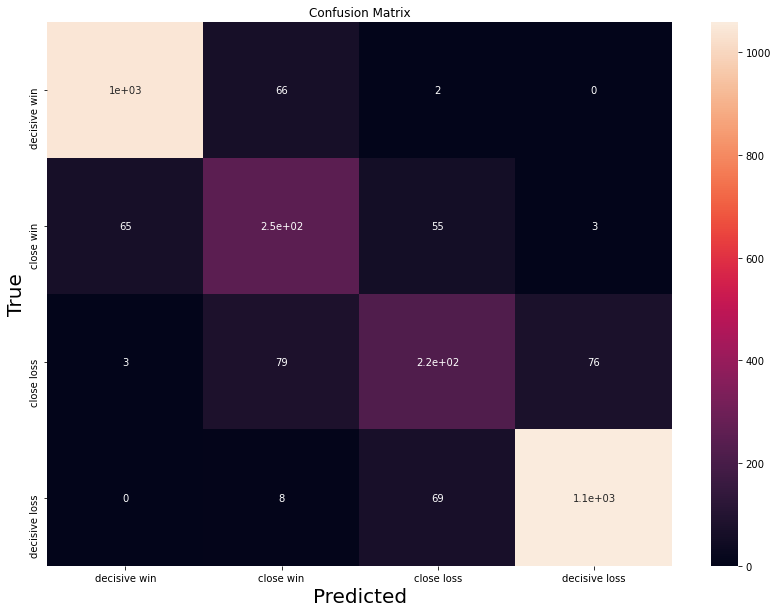

In [33]:
y_pred = svc_clf.predict(X_tez)

print(f'Test accuracy: {svc_clf.score(X_tez, y_te) * 100}%')
print(f'Best parameters: {svc_clf.best_params_}')
print(f'\n{classification_report(y_te, y_pred, target_names=class_names)}')

cm = confusion_matrix(y_te, y_pred)
plt.figure(figsize = (14,10))
plt.title("Confusion Matrix")
fig = sn.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted", fontsize=20)
plt.ylabel("True", fontsize=20)
plt.show(fig)

### Random Forest

In [34]:
y = df.winrate
y = y.apply(classify_winrate)
X = df.drop('winrate', axis=1)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)
X_trz, mean_tr, var_tr = scale_matrix(X_tr.values.tolist())
X_tez, _, _ = scale_matrix(X_te.values.tolist(), mean_tr, var_tr)

param_grid = [
  {'n_estimators': [10, 100, 1000, 2000], 'criterion': ['gini', 'entropy'], 
   'max_depth': [10, 50, 100, None], 'max_features': ['log2', 'sqrt']}
]

In [13]:
rf_clf = GridSearchCV(estimator=RandomForestClassifier(random_state=2), param_grid=param_grid, cv=3, verbose=1, n_jobs=6)
rf_clf = rf_clf.fit(X_trz, y_tr)


Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 192 out of 192 | elapsed:  9.7min finished


Test accuracy: 96.36666666666667%
Best parameters: {'criterion': 'entropy', 'max_depth': 50, 'max_features': 'log2', 'n_estimators': 2000}

               precision    recall  f1-score   support

 decisive win       0.98      0.99      0.98      1144
    close win       0.95      0.91      0.93       374
   close loss       0.92      0.86      0.89       375
decisive loss       0.97      0.99      0.98      1107

     accuracy                           0.96      3000
    macro avg       0.95      0.94      0.95      3000
 weighted avg       0.96      0.96      0.96      3000



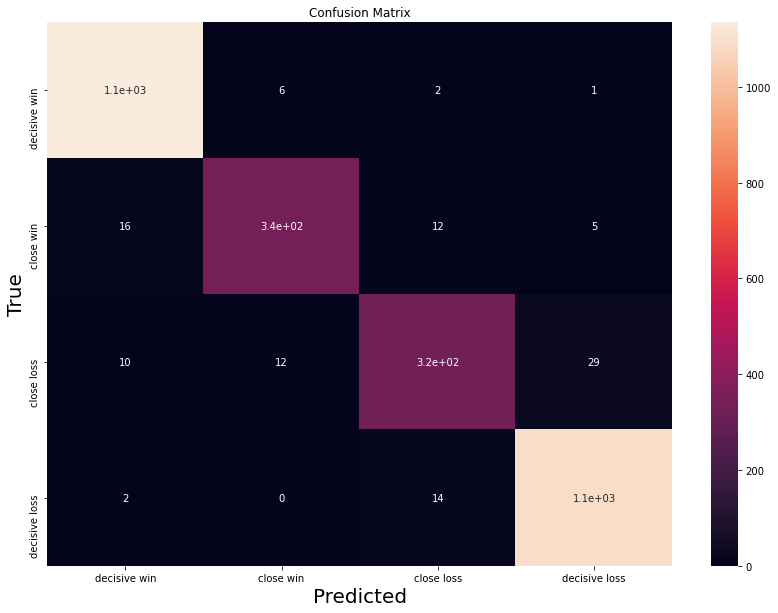

In [35]:
y_pred = rf_clf.predict(X_tez)

print(f'Test accuracy: {rf_clf.score(X_tez, y_te) * 100}%')
print(f'Best parameters: {rf_clf.best_params_}')
print(f'\n{classification_report(y_te, y_pred, target_names=class_names)}')

cm = confusion_matrix(y_te, y_pred)
plt.figure(figsize = (14,10))
plt.title("Confusion Matrix")
fig = sn.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted", fontsize=20)
plt.ylabel("True", fontsize=20)
plt.show(fig)

Text(0.5, 0, 'Random Forest Feature Importance')

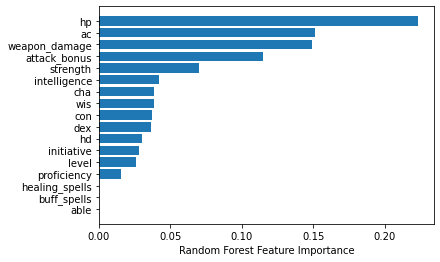

In [16]:
sorted_idx = rf_clf.best_estimator_.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], rf_clf.best_estimator_.feature_importances_[sorted_idx])

# sorted_idx = rf_clf.feature_importances_.argsort()
# plt.barh(X.columns[sorted_idx], rf_clf.feature_importances_[sorted_idx])

plt.xlabel("Random Forest Feature Importance")


In [ ]:
# TODO: do more graphs from here https://github.com/parrt/dtreeviz
viz = dtreeviz(rf_clf.best_estimator_.estimators_[0], X, y, feature_names=X.columns, target_name="winrate", class_names=class_names)


In [ ]:
viz.view()

### Neural Network

In [36]:
y = df.winrate
y = y.apply(classify_winrate)
X = df.drop('winrate', axis=1)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)
X_trz, mean_tr, var_tr = scale_matrix(X_tr.values.tolist())
X_tez, _, _ = scale_matrix(X_te.values.tolist(), mean_tr, var_tr)

param_grid = [
  {'activation': ['logistic', 'relu'], 'solver': ['adam', 'lbfgs'], 'max_iter': [500],
   'alpha': [0.000001, 0.00001, 0.0001, 0.01], 'hidden_layer_sizes': [(100, 100, 100), (10, 10, 10), (100, 100), (10, 10), (100), (10)]}
]

In [18]:
nn_clf = GridSearchCV(estimator=MLPClassifier(), param_grid=param_grid, cv=3, verbose=1, n_jobs=6)
nn_clf = nn_clf.fit(X_trz, y_tr)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed: 16.5min
[Parallel(n_jobs=6)]: Done 288 out of 288 | elapsed: 23.0min finished
/Users/ben/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Test accuracy: 89.46666666666667%
Best parameters: {'activation': 'logistic', 'alpha': 1e-06, 'hidden_layer_sizes': (100, 100), 'max_iter': 500, 'solver': 'adam'}

               precision    recall  f1-score   support

 decisive win       0.94      0.97      0.95      1098
    close win       0.77      0.72      0.74       388
   close loss       0.71      0.69      0.70       370
decisive loss       0.94      0.95      0.95      1144

     accuracy                           0.89      3000
    macro avg       0.84      0.83      0.84      3000
 weighted avg       0.89      0.89      0.89      3000



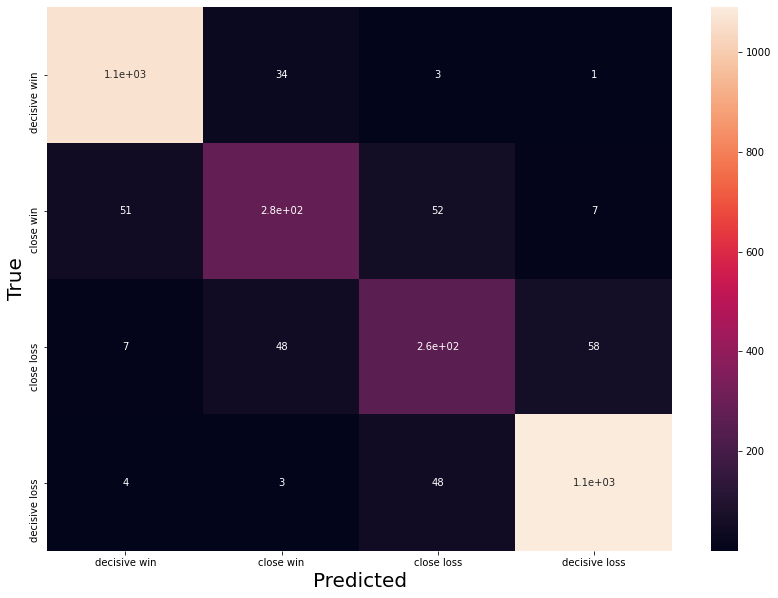

In [37]:
y_pred = nn_clf.predict(X_tez)

print(f'Test accuracy: {nn_clf.score(X_tez, y_te) * 100}%')
print(f'Best parameters: {nn_clf.best_params_}')
print(f'\n{classification_report(y_te, y_pred, target_names=class_names)}')

cm = confusion_matrix(y_te, y_pred)
plt.figure(figsize = (14,10))
fig = sn.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted", fontsize=20)
plt.ylabel("True", fontsize=20)
plt.show(fig)

## Binary Classification

### SVC

In [21]:
y = df.winrate
y = y.apply(classify_binary_winrate)
X = df.drop('winrate', axis=1)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)
X_trz, mean_tr, var_tr = scale_matrix(X_tr.values.tolist())
X_tez, _, _ = scale_matrix(X_te.values.tolist(), mean_tr, var_tr)

param_grid = [
  {'C': [1, 10, 100], 'kernel': ['linear']},
  {'C': [1, 10, 100], 'gamma': [0.1, 0.01, 0.001], 'kernel': ['rbf']},
]

In [22]:
svc_bin_clf = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=3, verbose=1, n_jobs=6)
svc_bin_clf = svc_bin_clf.fit(X_trz, y_tr)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  36 out of  36 | elapsed:   36.4s finished


Test accuracy: 94.1%
Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

              precision    recall  f1-score   support

         win       0.93      0.95      0.94      1474
        loss       0.95      0.93      0.94      1526

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



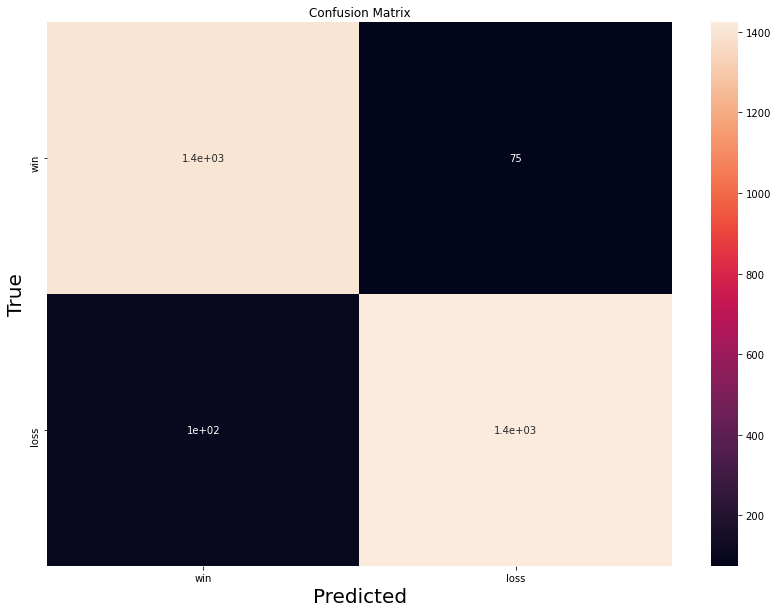

In [23]:
y_pred = svc_bin_clf.predict(X_tez)

print(f'Test accuracy: {svc_bin_clf.score(X_tez, y_te) * 100}%')
print(f'Best parameters: {svc_bin_clf.best_params_}')
print(f'\n{classification_report(y_te, y_pred, target_names=binary_class_names)}')

cm = confusion_matrix(y_te, y_pred)
plt.figure(figsize = (14,10))
plt.title("Confusion Matrix")
fig = sn.heatmap(cm, annot=True, xticklabels=binary_class_names, yticklabels=binary_class_names)
plt.xlabel("Predicted", fontsize=20)
plt.ylabel("True", fontsize=20)
plt.show(fig)

### Random Forest

In [24]:
y = df.winrate
y = y.apply(classify_binary_winrate)
X = df.drop('winrate', axis=1)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)
X_trz, mean_tr, var_tr = scale_matrix(X_tr.values.tolist())
X_tez, _, _ = scale_matrix(X_te.values.tolist(), mean_tr, var_tr)

param_grid = [
  {'n_estimators': [10, 100, 1000, 2000], 'criterion': ['gini', 'entropy'], 
   'max_depth': [10, 50, 100, None], 'max_features': ['log2', 'sqrt']}
]

In [25]:
rf_bin_clf = GridSearchCV(estimator=RandomForestClassifier(random_state=2), param_grid=param_grid, cv=3, verbose=1, n_jobs=6)
rf_bin_clf = rf_bin_clf.fit(X_trz, y_tr)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 192 out of 192 | elapsed:  7.8min finished


Test accuracy: 94.63333333333334%
Best parameters: {'criterion': 'gini', 'max_depth': 50, 'max_features': 'log2', 'n_estimators': 2000}

              precision    recall  f1-score   support

         win       0.94      0.95      0.95      1516
        loss       0.95      0.94      0.95      1484

    accuracy                           0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.95      0.95      0.95      3000



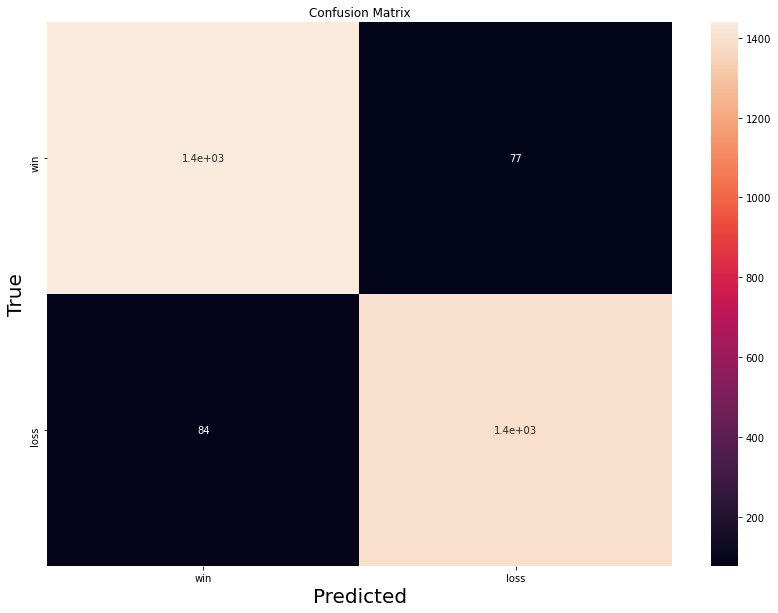

In [26]:
y_pred = rf_bin_clf.predict(X_tez)

print(f'Test accuracy: {rf_bin_clf.score(X_tez, y_te) * 100}%')
print(f'Best parameters: {rf_bin_clf.best_params_}')
print(f'\n{classification_report(y_te, y_pred, target_names=binary_class_names)}')

cm = confusion_matrix(y_te, y_pred)
plt.figure(figsize = (14,10))
plt.title("Confusion Matrix")
fig = sn.heatmap(cm, annot=True, xticklabels=binary_class_names, yticklabels=binary_class_names)
plt.xlabel("Predicted", fontsize=20)
plt.ylabel("True", fontsize=20)
plt.show(fig)

Text(0.5, 0, 'Random Forest Feature Importance')

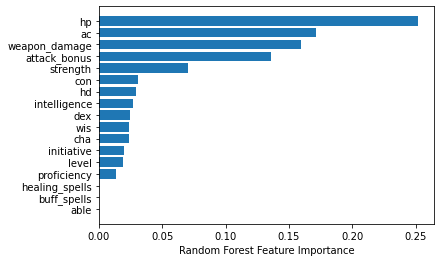

In [27]:
sorted_idx = rf_bin_clf.best_estimator_.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], rf_bin_clf.best_estimator_.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Neural Network

In [28]:
y = df.winrate
y = y.apply(classify_binary_winrate)
X = df.drop('winrate', axis=1)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)
X_trz, mean_tr, var_tr = scale_matrix(X_tr.values.tolist())
X_tez, _, _ = scale_matrix(X_te.values.tolist(), mean_tr, var_tr)

param_grid = [
  {'activation': ['logistic', 'relu'], 'solver': ['adam', 'lbfgs'], 'max_iter': [500],
   'alpha': [0.000001, 0.00001, 0.0001, 0.01], 'hidden_layer_sizes': [(100, 100), (10, 10), (100), (10)]}
]

In [29]:
nn_bin_clf = GridSearchCV(estimator=MLPClassifier(), param_grid=param_grid, cv=3, verbose=1, n_jobs=6)
nn_bin_clf = nn_bin_clf.fit(X_trz, y_tr)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 192 out of 192 | elapsed:  8.7min finished


Test accuracy: 94.3%
Best parameters: {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': 10, 'max_iter': 500, 'solver': 'adam'}

              precision    recall  f1-score   support

         win       0.94      0.95      0.94      1509
        loss       0.95      0.94      0.94      1491

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



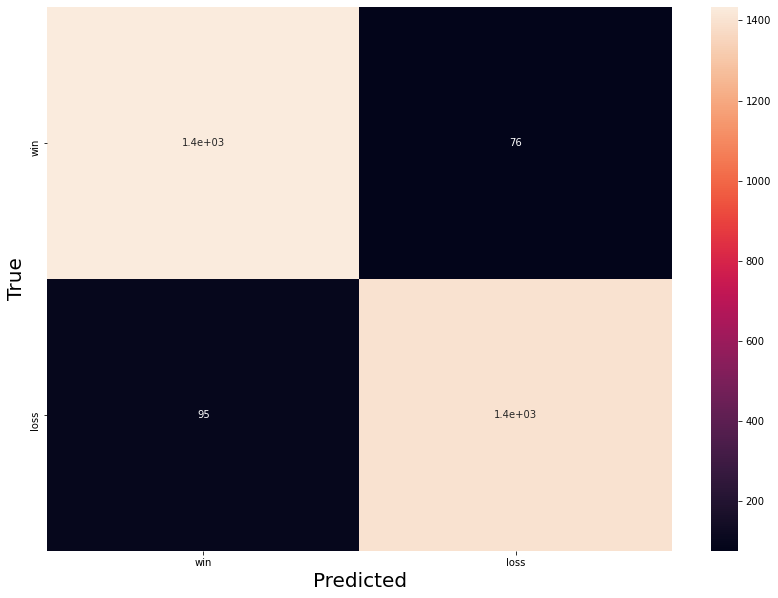

In [30]:
y_pred = nn_bin_clf.predict(X_tez)

print(f'Test accuracy: {nn_bin_clf.score(X_tez, y_te) * 100}%')
print(f'Best parameters: {nn_bin_clf.best_params_}')
print(f'\n{classification_report(y_te, y_pred, target_names=binary_class_names)}')

cm = confusion_matrix(y_te, y_pred)
plt.figure(figsize = (14,10))
fig = sn.heatmap(cm, annot=True, xticklabels=binary_class_names, yticklabels=binary_class_names)
plt.xlabel("Predicted", fontsize=20)
plt.ylabel("True", fontsize=20)
plt.show(fig)